# 1. Prepare the data

In this part, we will load all the images and data in the json files using the custom dataset, and display the dataform containing all the data.

Mount the google drive.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Import all the packages.

In [2]:
import os
import json
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.utils import make_grid, save_image

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

Unzip all the data.

In [ ]:
!tar -xvzf /content/gdrive/MyDrive/Selected_Storms_curated_to_zip.tgz

Create the custom dataset.

In [3]:
class HurricaneDataset(Dataset):
    def __init__(self, subfolder_path, transform=None, image_size=(366, 366), channels=3): # noqa
        """
        Args:
            - subfolder_path (string): Path to subfolder for specific hurricane
            - transform (callable, optional): Transform to be applied on an
            image.
            - image_size (tuple): Size to which images are resized.
            - channels (int): Number of channels in the images.
        """
        self.subfolder_path = subfolder_path
        self.channels = channels
        self.transform = transform if transform else self.default_transform(image_size) # noqa
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        file_ls = sorted(os.listdir(self.subfolder_path))
        for file in file_ls:
            if file.endswith('.jpg') and not file.startswith('._'):
                base_name = file[:-4]
                image_path = os.path.join(self.subfolder_path, file)
                label_path = os.path.join(self.subfolder_path, base_name + '_label.json') # noqa
                feature_path = os.path.join(self.subfolder_path, base_name + '_features.json') # noqa
                samples.append((image_path, label_path, feature_path, file))
        return samples

    def default_transform(self, image_size):
        """Define the default transformation."""
        transform_list = [transforms.Resize(image_size)]

        if self.channels == 1:
            transform_list.append(transforms.Grayscale(num_output_channels=self.channels)) # noqa
        elif self.channels == 3:
            transform_list.append(transforms.Lambda(lambda img: img.convert('RGB'))) # noqa

        transform_list.append(transforms.ToTensor())
        return transforms.Compose(transform_list)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label_path, feature_path, image_name = self.samples[idx]

        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)

        with open(label_path, 'r') as file:
            label = json.load(file)

        with open(feature_path, 'r') as file:
            features = json.load(file)

        step = int(os.path.basename(image_path).split('_')[1].split('.')[0])

        sample = {
            'image': image,
            'image_name': image_name,
            'step': step,
            'storm_id': features['storm_id'],
            'relative_time': int(features['relative_time']),
            'ocean': int(features['ocean']),
            'wind_speed': int(label['wind_speed'])
        }

        return sample

    def to_dataframe(self):
        data = [self[i] for i in range(len(self))]
        df = pd.DataFrame(data)
        df = df.sort_values(by='step').reset_index(drop=True)
        return df

    def save_to_csv(self, csv_directory):
        df = self.to_dataframe()
        storm_id = df['storm_id'].iloc[0]
        csv_filename = f"{storm_id}_data.csv"
        csv_path = os.path.join(root_dir, csv_directory, csv_filename)
        df.to_csv(csv_path, index=False)
        return csv_path

    def get_transformed_images(self):
        """Return a list of transformed images"""
        images = []
        for i in range(len(self)):
            images.append(self[i]['image'])
        return images

    def get_transformed_image_tensors(self):
        """Return a tensor of all images in the dataset
        with shape (366, 366, number of images)."""
        if self.channels != 1:
            raise ValueError("This function is only applicable for single-channel images.") # noqa

        image_tensors = []
        for i in range(len(self)):
            image_tensor = self[i]['image']
            image_tensors.append(image_tensor.squeeze(0))

        all_images_tensor = torch.stack(image_tensors, dim=2)
        return all_images_tensor

root_dir = '/content'

Get all the names of the storms.

In [5]:
def get_directory_names(path):
    """ Return a list of the names of all folders in the specified path """
    directory_names = [folder for folder in sorted(os.listdir(path)) if os.path.isdir(os.path.join(path, folder))]
    return pd.Series(directory_names)

image_path = os.path.join(root_dir, 'Selected_Storms_curated_to_zip')
storm_name = get_directory_names(image_path)
print(storm_name)

0     bkh
1     blq
2     dzw
3     eoi
4     fgi
5     fna
6     gic
7     gkf
8     gme
9     hig
10    ing
11    ipa
12    kqu
13    mtw
14    ojv
15    pjj
16    psz
17    pvj
18    qpq
19    rml
20    sxb
21    vxf
22    vye
23    woc
24    wsy
25    xjo
26    yfn
27    ywf
28    zny
29    ztb
dtype: object


Load the datasets and create the dataframes for each storm.

In [6]:
storm_dataset = [HurricaneDataset(os.path.join(image_path, name), image_size=(366, 366), channels=1) for name in storm_name]
storm_df = [dataset.to_dataframe() for dataset in storm_dataset]

Save the csv files including all the data for each storm.

In [8]:
storm_data_folder = 'storm_data'
os.makedirs(storm_data_folder, exist_ok=True)

for dataset in storm_dataset:
  dataset.save_to_csv(storm_data_folder)

Choose one storm to explore. (storm_num=3 corresponds to the storm named as 'eoi')

In [1]:
storm_num = 3

Display the first five rows of the chosen dataframe.

In [10]:
storm_df[storm_num].head()

image   image_name  step  \
0  [[[tensor(0.0980), tensor(0.0980), tensor(0.09...  eoi_000.jpg     0   
1  [[[tensor(0.0824), tensor(0.0902), tensor(0.09...  eoi_001.jpg     1   
2  [[[tensor(0.0980), tensor(0.0980), tensor(0.09...  eoi_002.jpg     2   
3  [[[tensor(0.0549), tensor(0.0471), tensor(0.04...  eoi_003.jpg     3   
4  [[[tensor(0.0980), tensor(0.0824), tensor(0.06...  eoi_004.jpg     4   

  storm_id  relative_time  ocean  wind_speed  
0      eoi              0      1          25  
1      eoi           1803      1          25  
2      eoi           3601      1          25  
3      eoi           5401      1          25  
4      eoi           7201      1          25

# 2. Get the number of images of the storm

Firstly, we want to count the number of images in each storm to see if there are any imbalances in the datasets.

Display the shape of the chosen dataframe.

In [14]:
storm_df[storm_num].shape

(488, 7)

Print the number of images for each storm and also the total number of images.

In [17]:
image_count = [df.shape[0] for df in storm_df]
print(f"Number of images for each storm: {image_count}")
print(f"Total number of data: {sum(image_count)}")

Number of images for each storm: [410, 252, 367, 488, 249, 326, 467, 340, 209, 342, 498, 449, 308, 350, 420, 235, 379, 232, 259, 265, 243, 227, 249, 173, 477, 317, 181, 155, 402, 258]
Total number of data: 9527


Plot the bar graph showing the number of imagaes for each storm. This will be helpful to split the train and test dataset reasonably.

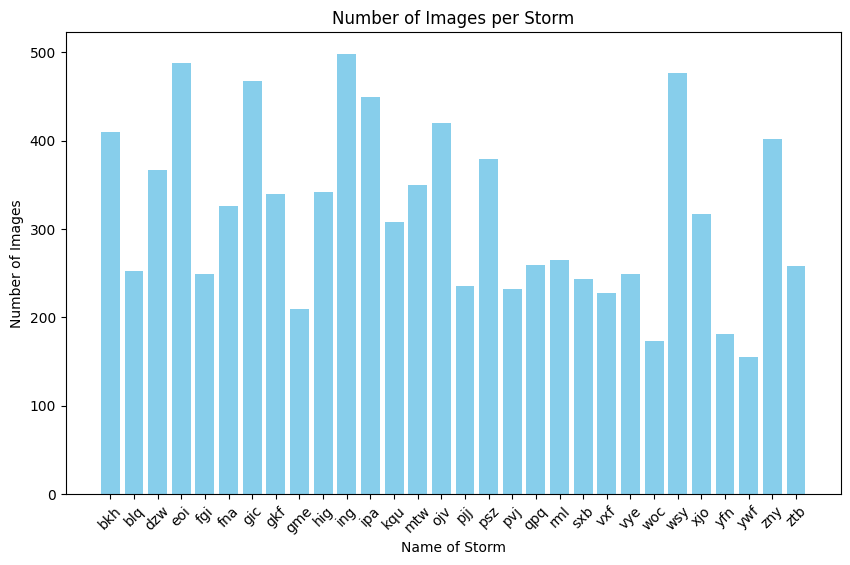

In [ ]:
plt.figure(figsize=(10, 6))

plt.bar(storm_name, image_count, color='skyblue')
plt.xlabel('Name of Storm')
plt.ylabel('Number of Images')
plt.title('Number of Images per Storm')

plt.xticks(rotation=45)

plt.show()

From the plot above, it can be seen that the number of images per storm varies from around 170 to the maximum of around 500. There are imbalances in the datasets.

# 3. Explore the distribution of label (wind speed)

Then we will explore the features of the label, (which is the wind speed), including its range, distribution and its effect on the images.

Print all the unique values of wind speeds for the chosen storm.

In [19]:
# Get the unique values of wind speed and sort them in ascending order
print(sorted(storm_df[storm_num]['wind_speed'].unique()))

[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125]


Display the descriptive statistics of the wind speeds for the chosen storm.

In [20]:
# Get statistics of wind speeds
storm_df[storm_num]['wind_speed'].describe()

count    488.000000
mean      68.325820
std       26.194628
min       25.000000
25%       55.000000
50%       65.000000
75%       80.000000
max      125.000000
Name: wind_speed, dtype: float64

Plot the histogram showing the distribution of wind speeds for the chosen storm.

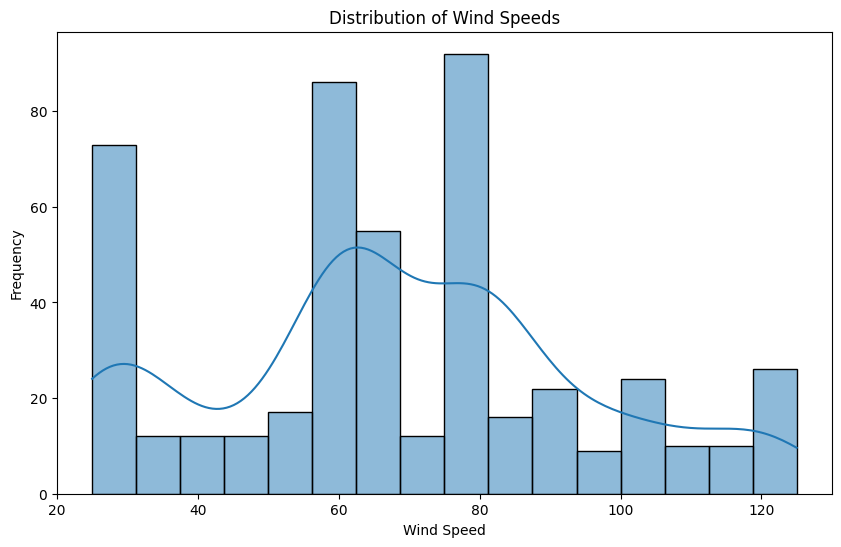

In [18]:
# Visualize the distribution of wind speeds
plt.figure(figsize=(10, 6))
sns.histplot(storm_df[storm_num]['wind_speed'], kde=True)
plt.title('Distribution of Wind Speeds')
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.show()

Define a function to display a image of the storm with a given speed.

In [24]:
def show_image_at_wind_speed(dataset, wind_speed):
    # Find samples for specific wind speeds
    matching_samples = dataset[dataset['wind_speed'] == wind_speed]

    if not matching_samples.empty:
        # Get the image of the first matching sample
        image = matching_samples.iloc[0]['image']
        plt.imshow(image.squeeze(), cmap='gray')  # Convert channel order from (C, H, W) to (H, W, C)
        plt.title(f"Wind Speed: {wind_speed}")
        plt.axis('off')
        plt.show()
    else:
        print(f"No image found for wind speed {wind_speed}")

Display an image of the given storm with the minimum speed.

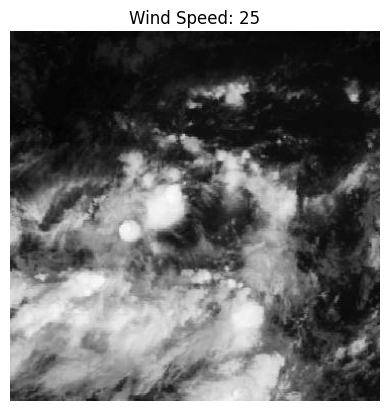

In [25]:
# Image with low wind speed
show_image_at_wind_speed(storm_df[storm_num], storm_df[storm_num]['wind_speed'].min())

Display an image of the given storm with the maximum speed.

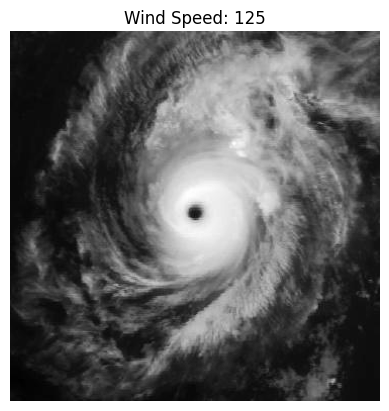

In [26]:
# Image with high wind speed
show_image_at_wind_speed(storm_df[storm_num], storm_df[storm_num]['wind_speed'].max())

Comparing the two images above, it can be seen that when the wind speed is relatively low, the white pixels are dispersive and irregular. However, when the wind speed is relatively high, there is a distinct eye of storm. Therefore, the features in the images can be used to predict the wind speed.

# 4. Analyse the time series

As the datasets are chronological, we want to analyse how the time changes.

Plot the scatter diagram of the wind speed over relative time for the chosen storm.

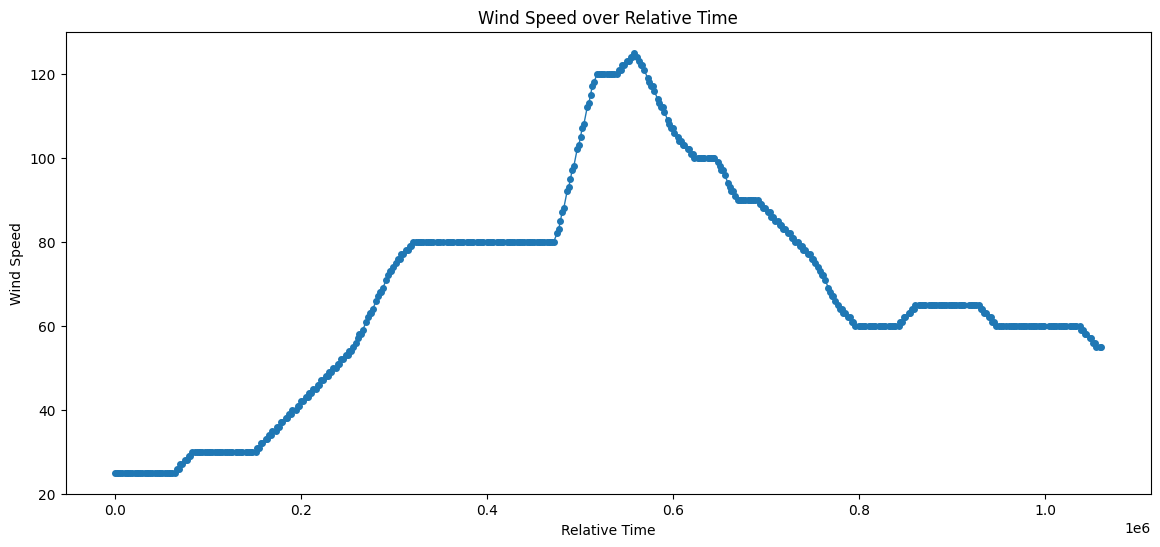

In [73]:
# Time-series plot for wind speed over relative time
plt.figure(figsize=(14, 6))
plt.plot(storm_df[storm_num]['relative_time'], storm_df[storm_num]['wind_speed'], marker='o', markersize=4, linestyle='-', linewidth=1)
plt.title('Wind Speed over Relative Time')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.show()

From the plot above, it can be seen that the time does not change envenly. Then we want to observe the time change for all the storms.

Plot the scatter diagram of the wind speed over relative time for all the storms.

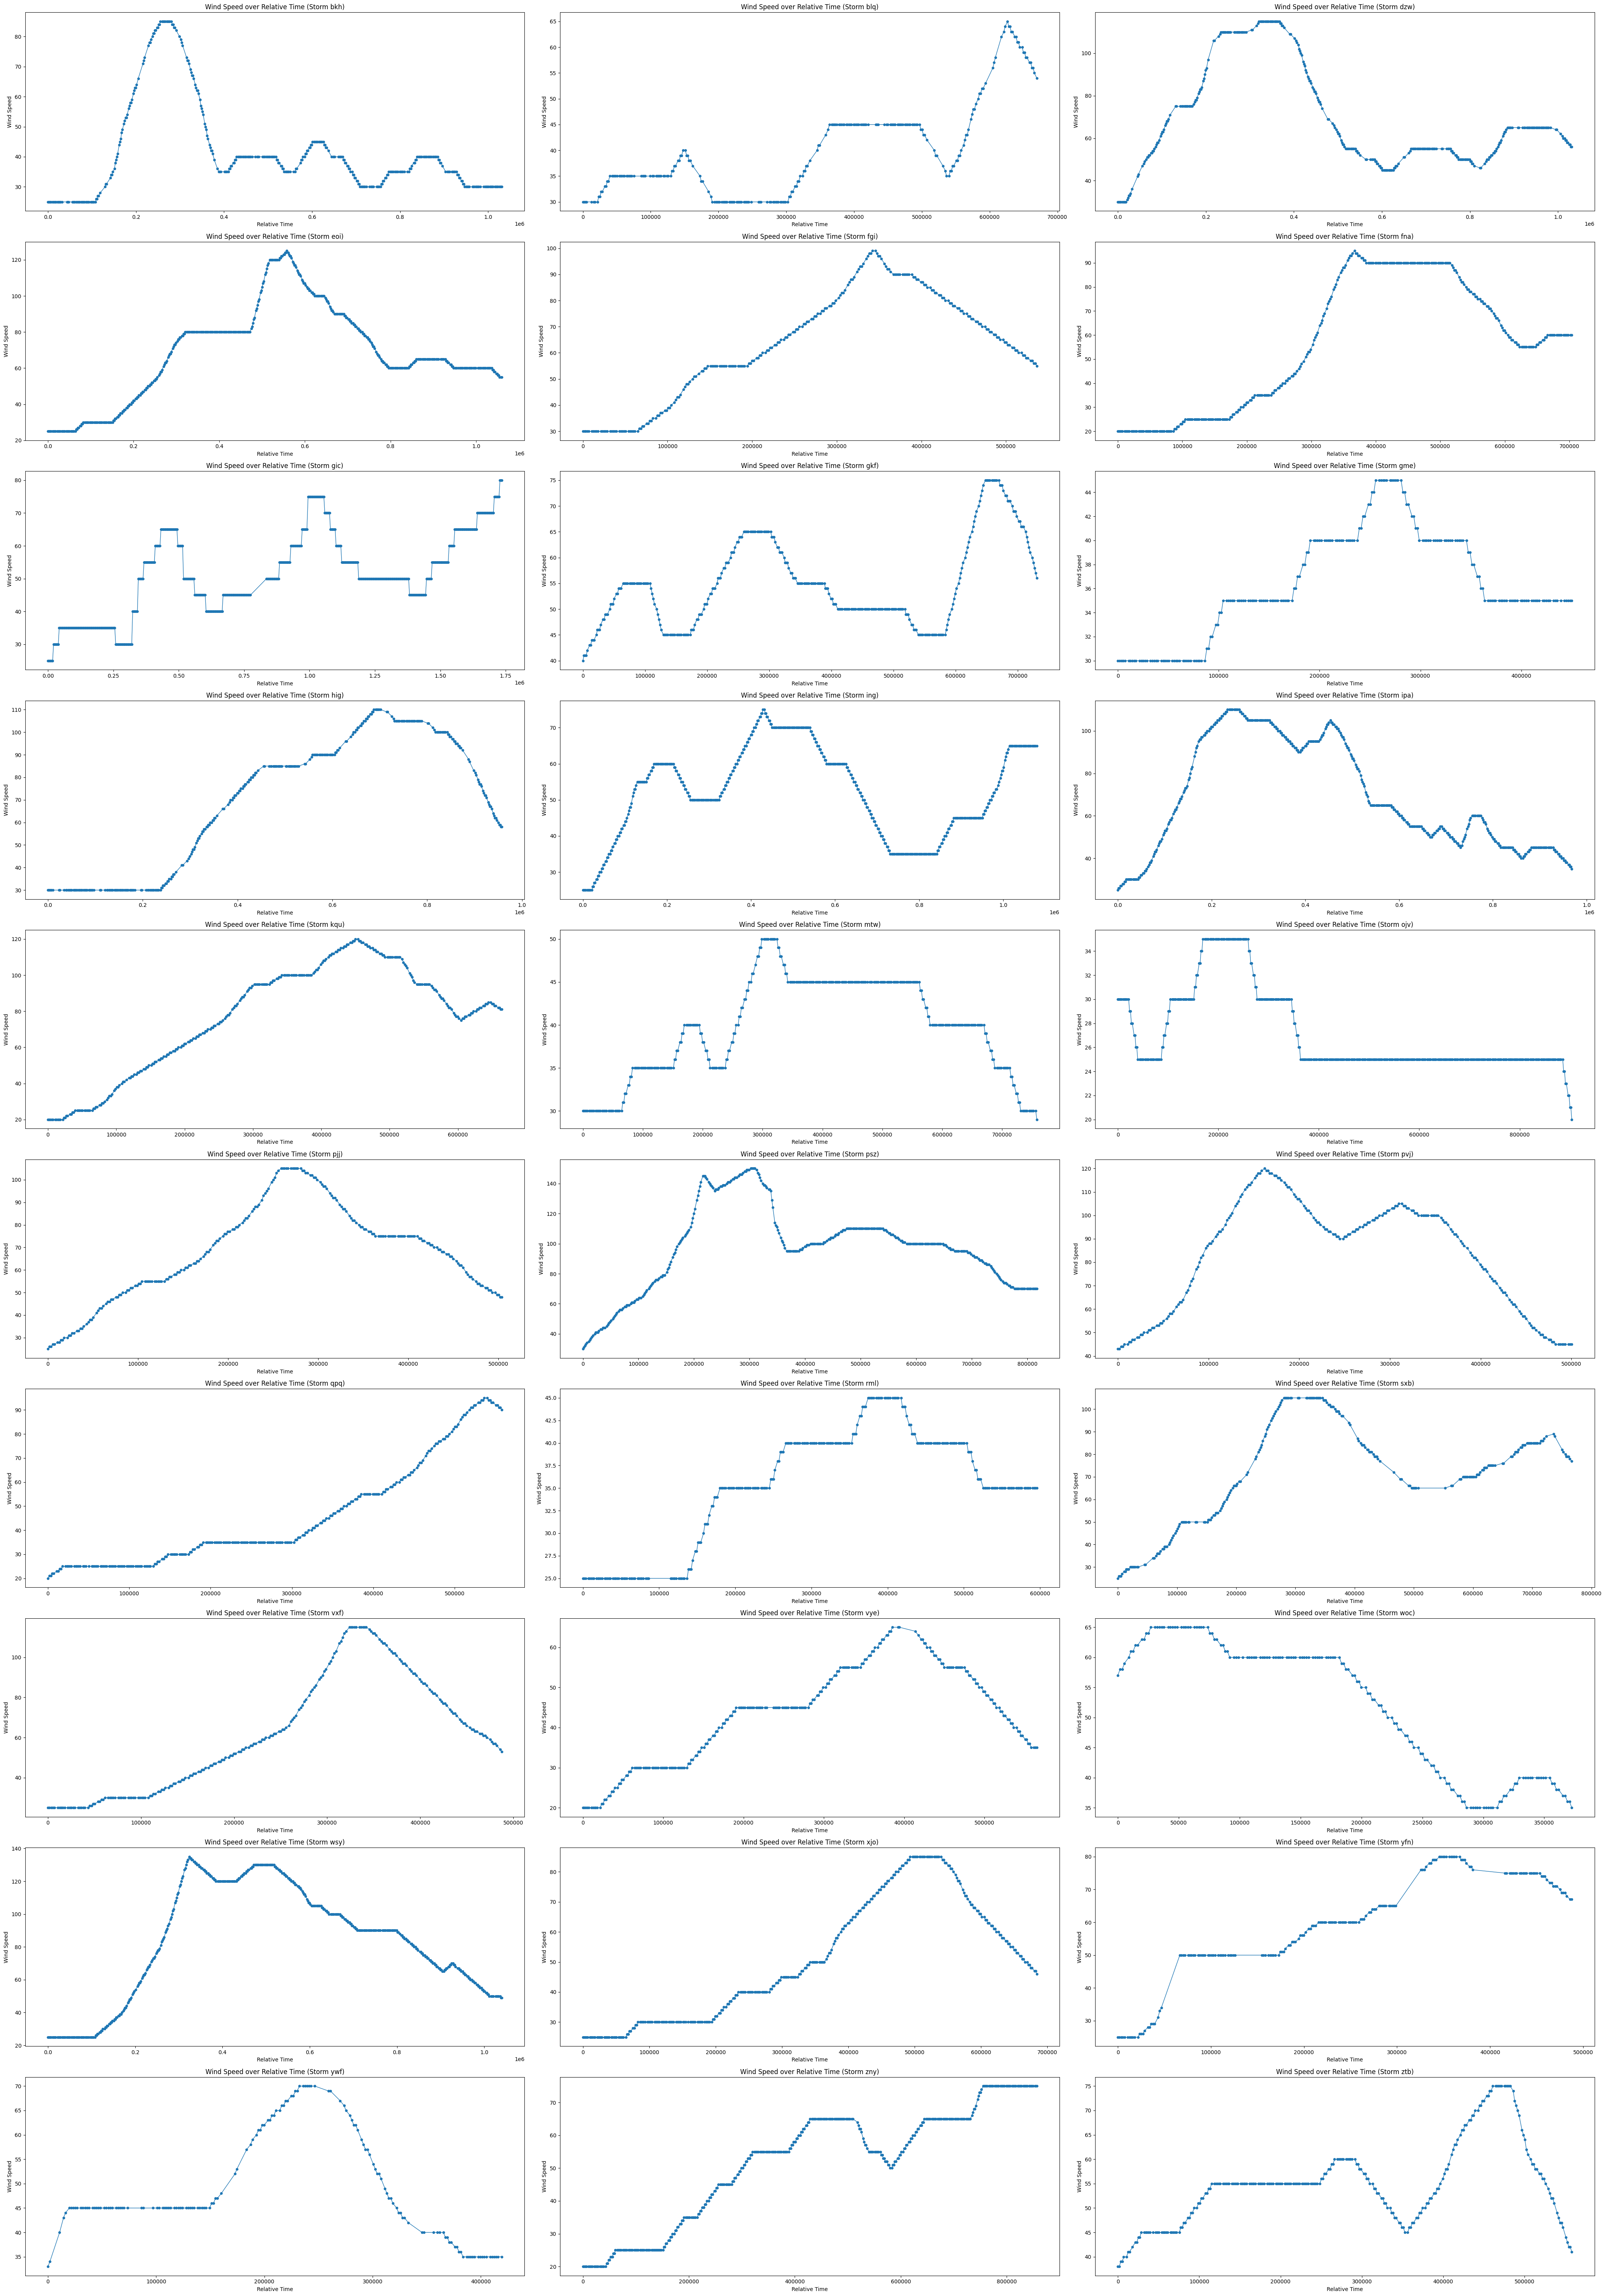

In [9]:
num_storms = 30  # Total number of storms
num_cols = 3     # Number of columns in the subplot grid
num_rows = num_storms // num_cols + (num_storms % num_cols > 0)  # Calculate the number of rows needed

plt.figure(figsize=(14 * num_cols, 6 * num_rows))

for i in range(num_storms):
    plt.subplot(num_rows, num_cols, i+1)  # Create a subplot for each storm
    plt.plot(storm_df[i]['relative_time'], storm_df[i]['wind_speed'], marker='o', markersize=4, linestyle='-', linewidth=1)
    plt.title(f'Wind Speed over Relative Time (Storm {storm_name[i]})')
    plt.xlabel('Relative Time')
    plt.ylabel('Wind Speed')

plt.tight_layout()  # Adjust the layout
plt.show()

Find the time differences between each two samples for the chosen storm.

In [ ]:
differences = storm_df[storm_num]['relative_time'].diff()
differences = differences.fillna(0)
print(differences)
# Print all the unique values of time steps
print(sorted(differences.unique()))

0         0.0
1      1803.0
2      1798.0
3      1800.0
4      1800.0
        ...  
483    1800.0
484    1801.0
485    1799.0
486    3601.0
487    1799.0
Name: relative_time, Length: 488, dtype: float64
[0.0, 1797.0, 1798.0, 1799.0, 1800.0, 1801.0, 1802.0, 1803.0, 3598.0, 3599.0, 3600.0, 3601.0, 3602.0, 3603.0, 5397.0, 5398.0]


Find the number and calculate the percentage of outliers in time steps (which are much larger than 1800) for the chosen storm.


In [ ]:
count = (differences > 1805).sum()
percentage = count / len(differences)
print(f"Number of large time steps: {count}")
print(f"Percentage of large time steps: {percentage}")

Number of large time steps: 100
Percentage of large time steps: 0.20491803278688525


Find the number and calculate the percentage of outliers in time steps (which are much larger than 1800) for all the storms.

In [27]:
differences = [storm_df[i]['relative_time'].diff().fillna(0) for i in range(len(storm_name))]

counts = [len(series[series > 1805]) for series in differences]
percentages = [(count / len(series)) * 100 for series, count in zip(differences, counts)]

# Print the results
for i, series in enumerate(differences):
    print(f"Storm {storm_name[i]}:")
    print(f"Number of large time steps: {counts[i]}")
    print(f"Percentage of large time steps: {percentages[i]:.2f}%")
    print()

Storm bkh:
Number of large time steps: 104
Percentage of large time steps: 25.37%

Storm blq:
Number of large time steps: 71
Percentage of large time steps: 28.17%

Storm dzw:
Number of large time steps: 108
Percentage of large time steps: 29.43%

Storm eoi:
Number of large time steps: 100
Percentage of large time steps: 20.49%

Storm fgi:
Number of large time steps: 50
Percentage of large time steps: 20.08%

Storm fna:
Number of large time steps: 67
Percentage of large time steps: 20.55%

Storm gic:
Number of large time steps: 466
Percentage of large time steps: 99.79%

Storm gkf:
Number of large time steps: 67
Percentage of large time steps: 19.71%

Storm gme:
Number of large time steps: 42
Percentage of large time steps: 20.10%

Storm hig:
Number of large time steps: 100
Percentage of large time steps: 29.24%

Storm ing:
Number of large time steps: 103
Percentage of large time steps: 20.68%

Storm ipa:
Number of large time steps: 89
Percentage of large time steps: 19.82%

Storm kqu:

Most of the time steps should be around 1800. However, from the results above, it can be seen that there are around 20% of outliers that are larger than 1800. And the storm 'gic' is an exception. After inspecting this strom, it is found that the majority of the time steps for this storm are 3600 rather than 1800. Therefore, dealing with different time steps is a challenging part.

# 5. Analyze the influence of ocean

As the feature of 'ocean' is provided for each piece of data, we can analyze the influence of 'ocean' on the wind speed.

Find the feature 'ocean' for each storm.

In [8]:
ocean_values = [df['ocean'].unique() for df in storm_df]

ocean_list = [arr[0] for arr in ocean_values]

print(ocean_list)

for i, values in enumerate(ocean_list):
    print(f"Unique values in 'ocean' column for storm {i}: {values}")

[1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1]
Unique values in 'ocean' column for storm 0: 1
Unique values in 'ocean' column for storm 1: 1
Unique values in 'ocean' column for storm 2: 1
Unique values in 'ocean' column for storm 3: 1
Unique values in 'ocean' column for storm 4: 1
Unique values in 'ocean' column for storm 5: 1
Unique values in 'ocean' column for storm 6: 2
Unique values in 'ocean' column for storm 7: 2
Unique values in 'ocean' column for storm 8: 1
Unique values in 'ocean' column for storm 9: 1
Unique values in 'ocean' column for storm 10: 1
Unique values in 'ocean' column for storm 11: 1
Unique values in 'ocean' column for storm 12: 1
Unique values in 'ocean' column for storm 13: 1
Unique values in 'ocean' column for storm 14: 1
Unique values in 'ocean' column for storm 15: 1
Unique values in 'ocean' column for storm 16: 2
Unique values in 'ocean' column for storm 17: 1
Unique values in 'ocean' column for storm 18: 1
Unique 

Plot the scatter diagram of the wind speed over relative time for the storms with ocean of 1.

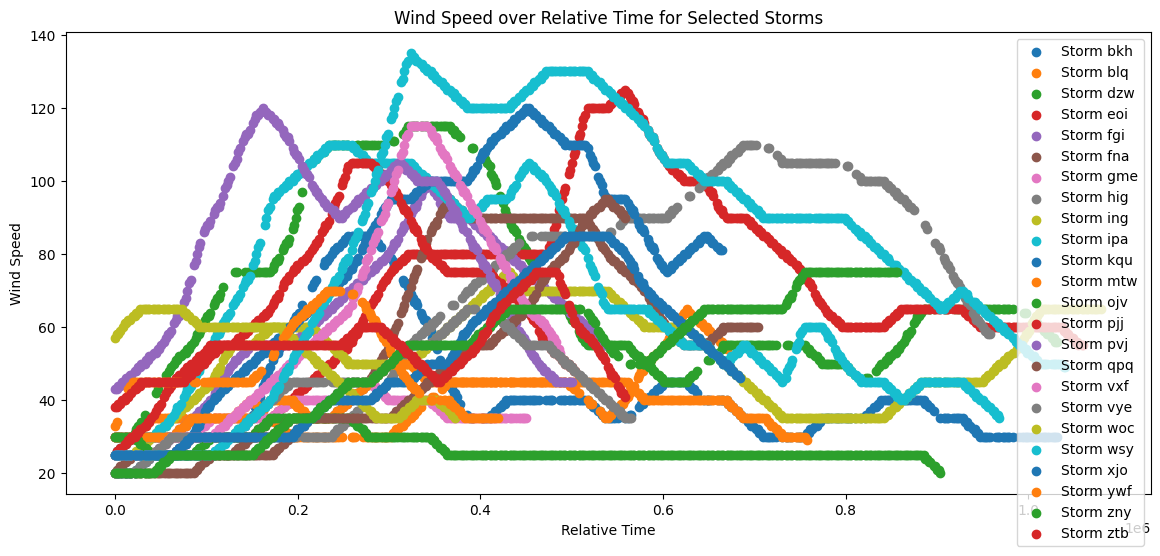

<Figure size 640x480 with 0 Axes>

In [10]:
# Get all indexes with a value of 1
indices = [i for i, x in enumerate(ocean_list) if x == 1]

plt.figure(figsize=(14, 6))

for idx in indices:
    plt.scatter(x='relative_time', y='wind_speed', data=storm_df[idx], label=f'Storm {storm_name[idx]}')

plt.title('Wind Speed over Relative Time for Selected Storms')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()


Plot the scatter diagram of the wind speed over relative time for the storms with ocean of 2.

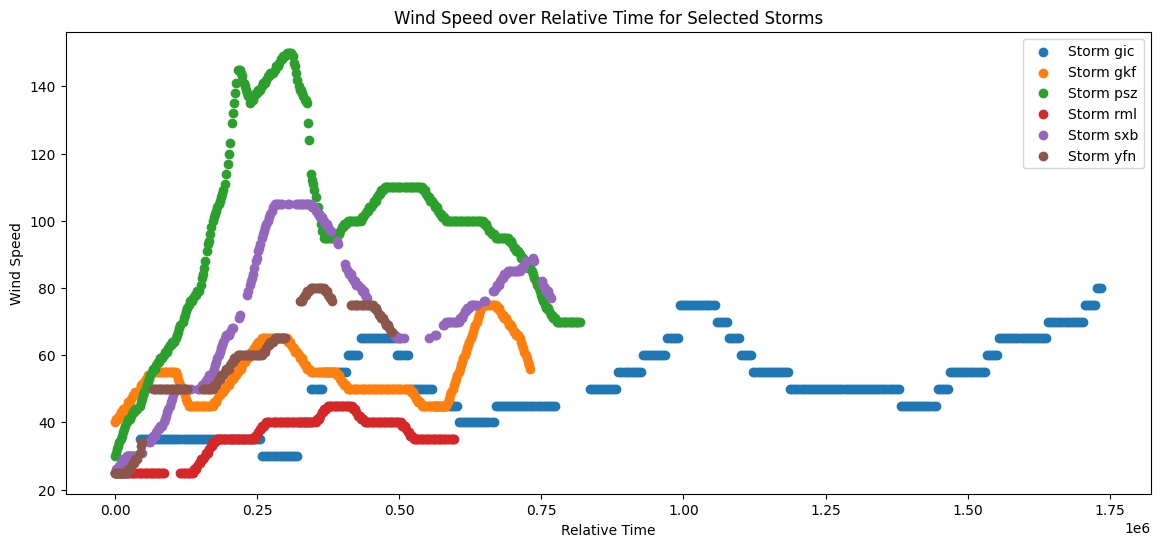

<Figure size 640x480 with 0 Axes>

In [11]:
# Get all indexes with a value of 1
indices = [i for i, x in enumerate(ocean_list) if x == 2]

plt.figure(figsize=(14, 6))

for idx in indices:
    plt.scatter(x='relative_time', y='wind_speed', data=storm_df[idx], label=f'Storm {storm_name[idx]}')

plt.title('Wind Speed over Relative Time for Selected Storms')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()


From the plots above, it can be observed that the speed tendency has no obvious relationship with the ocean. The storms on ocean 1 can be divided into more groups.

# 6. Analyze the pixel intensity for images

After exploring the data, we should also analyse the images.

Display the distribution of pixel intensity for the first image in the chosen storm.

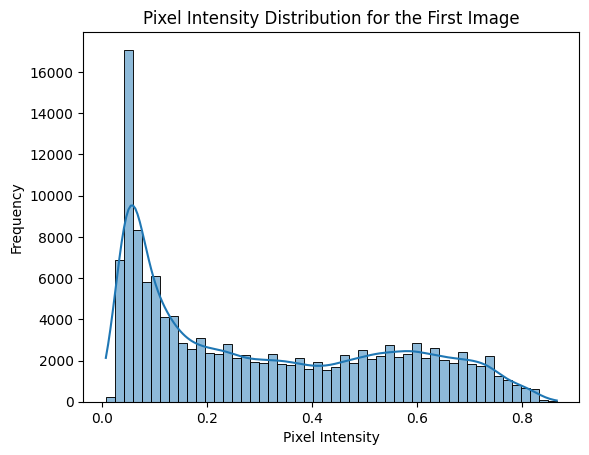

In [ ]:
storm_df[storm_num]['image'] = storm_df[storm_num]['image'].apply(lambda x: np.array(x).flatten())

# Assuming we're analyzing the first image
sns.histplot(storm_df[storm_num]['image'].iloc[0], bins=50, kde=True)
plt.title('Pixel Intensity Distribution for the First Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

By observing all the images, it is found that some of the images contain blank space, which may affect the training of the model.

Display a image with blank space on the bottom right corner, and plot its pixel intensity distribution.

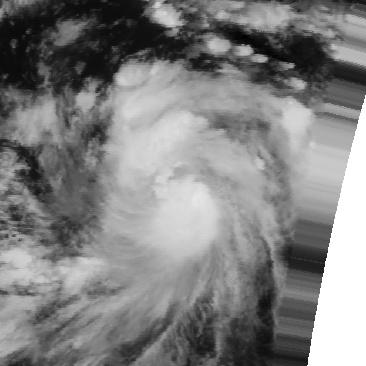

In [ ]:
path = os.path.join(image_path, 'ztb/ztb_010.jpg')

# Load the image
image = Image.open(path)

# Display the image
display(image)

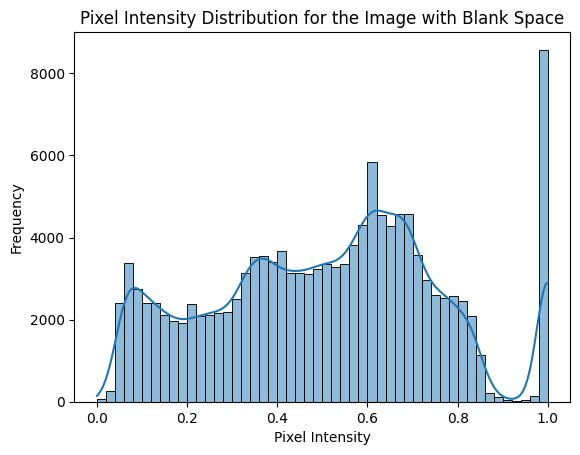

In [ ]:
storm_df[29]['image'] = storm_df[29]['image'].apply(lambda x: np.array(x).flatten())

# Assuming we're analyzing the first image
sns.histplot(storm_df[29]['image'].iloc[10], bins=50, kde=True)
plt.title('Pixel Intensity Distribution for the Image with Blank Space')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(storm_df[29]['image'].iloc[10].max())

1.0


Display a image with a linear blank space, and plot its pixel intensity distribution.

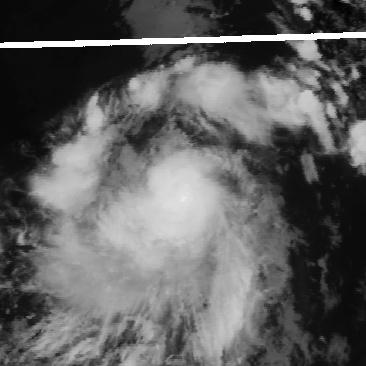

In [ ]:
path = os.path.join(image_path, 'ztb/ztb_048.jpg')

# Load the image
image = Image.open(path)

# Display the image
display(image)

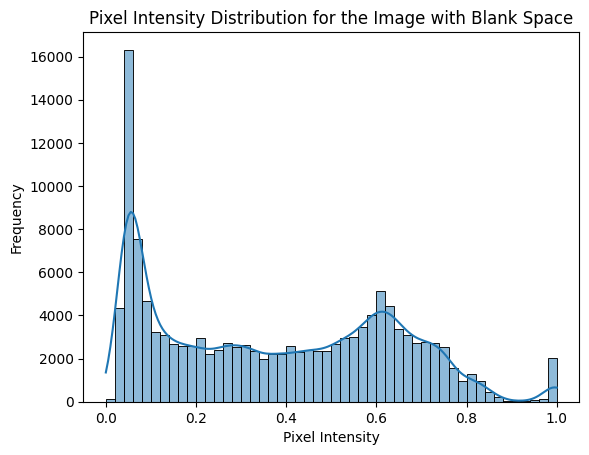

In [ ]:
storm_df[29]['image'] = storm_df[29]['image'].apply(lambda x: np.array(x).flatten())

# Assuming we're analyzing the first image
sns.histplot(storm_df[29]['image'].iloc[48], bins=50, kde=True)
plt.title('Pixel Intensity Distribution for the Image with Blank Space')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(storm_df[29]['image'].iloc[18].max())

1.0


Display a image without any blank space, and plot its pixel intensity distribution.

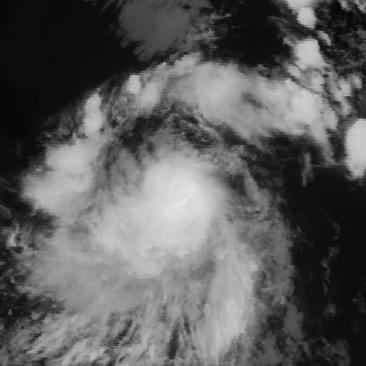

In [ ]:
path = os.path.join(image_path, 'ztb/ztb_049.jpg')

# Load the image
image = Image.open(path)

# Display the image
display(image)

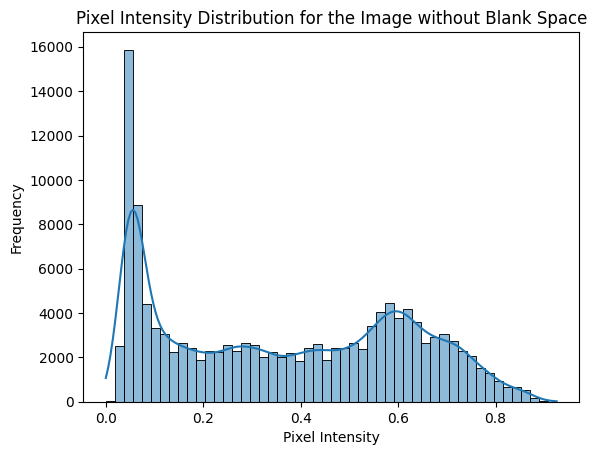

In [11]:
storm_df[29]['image'] = storm_df[29]['image'].apply(lambda x: np.array(x).flatten())

# Assuming we're analyzing the first image
sns.histplot(storm_df[29]['image'].iloc[49], bins=50, kde=True)
plt.title('Pixel Intensity Distribution for the Image without Blank Space')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(storm_df[29]['image'].iloc[49].max())

0.9254902


From the images and plots above, it can be seen that an image will have the blank space if it has the pixel intensity with the value of 1. Then by finding all the images with blank space, we can choose either remove those images or fill up the blank space.

Identify roughly the number of images containing blank spaces for each storm.

In [ ]:
image_with_intensity_one = []

# Loop through each DataFrame (storm)
for df in storm_df:
    # # For each DataFrame, check if each image contains at least one pixel intensity equal to 1
    # count = df['image'].apply(lambda img: np.any(np.array(img) == 1)).sum()
    # For each DataFrame, calculate the percentage of pixel intensity equal to 1 for each image
    count = df['image'].apply(lambda img: (np.sum(np.array(img) == 1) / np.array(img).size) > 0.005).sum()
    image_with_intensity_one.append(count)

print(pd.Series(image_with_intensity_one))

0      0
1      0
2      1
3      0
4      5
5      1
6      0
7      0
8      1
9      4
10     0
11    14
12     0
13    23
14     1
15     0
16     0
17    18
18     0
19    23
20     0
21     0
22     0
23    34
24    17
25     8
26     0
27     0
28     1
29    22
dtype: int64


# 7. Divide the 30 storms into several groups

To predict the results on the surprise storm more accurately, we can cluster the datasets, and train our model using the datasets that best match the surprise storm.

In [ ]:
!pip install tslearn

Use k-means method to cluster the storms with similar scores according to the wind speed.

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Set the path to the folder containing the CSV file
folder_path = 'storm_data'

# Get all CSV files in a folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# A list storing wind speed data
wind_speeds_list = []

# Iterate through each CSV file
for csv_file in csv_files:
    # Construct complete file paths
    file_path = os.path.join(folder_path, csv_file)

    # Read a CSV file as a DataFrame
    df = pd.read_csv(file_path)

    # Get the data in the wind speed column and store it as a numpy array
    wind_speeds = df['wind_speed'].values
    wind_speeds_list.append(wind_speeds)

# Get the maximum length of all wind speed data columns
max_length = max(len(wind_speeds) for wind_speeds in wind_speeds_list)

# Fill or truncate each wind speed data column
X_padded = [np.pad(wind_speeds, (0, max_length - len(wind_speeds))) for wind_speeds in wind_speeds_list]

# Convert wind speed data to numpy arrays
X = np.array(X_padded)

# Standardize time series data
X = TimeSeriesScalerMeanVariance().fit_transform(X)

# Define clustering model and train it
n_clusters = 5
model = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True)
y_pred = model.fit_predict(X)

# A list ostoring clustering results
cluster_results = []

# Add clustering results to the list
for i, csv_file in enumerate(csv_files):
    cluster_results.append([csv_file.replace('_data.csv', ''), int(y_pred[i])])

columns = ['storm_id', 'cluster']

df_storms = pd.DataFrame(cluster_results, columns=columns)

df_storms

135.108 --> 91.436 --> 89.073 --> 89.073 --> 


storm_id  cluster
0       bkh        2
1       woc        0
2       eoi        1
3       qpq        4
4       mtw        3
5       pvj        0
6       vye        4
7       xjo        3
8       ojv        2
9       zny        1
10      ywf        0
11      sxb        4
12      fgi        4
13      vxf        4
14      ing        3
15      kqu        3
16      ipa        2
17      gkf        2
18      gme        0
19      yfn        0
20      psz        2
21      blq        4
22      dzw        2
23      wsy        1
24      gic        1
25      hig        3
26      ztb        4
27      rml        4
28      pjj        4
29      fna        3

Print the storms in each cluster.

In [ ]:
# Group data by clusters
clustered_storms = df_storms.groupby('cluster')['storm_id'].unique()

# Show storms in each cluster
print("Storms in each cluster:")
for cluster in clustered_storms.index:
    print(f"Cluster {cluster}: {clustered_storms[cluster]}")

Storms in each cluster:
Cluster 0: ['woc' 'pvj' 'ywf' 'gme' 'yfn']
Cluster 1: ['eoi' 'zny' 'wsy' 'gic']
Cluster 2: ['bkh' 'ojv' 'ipa' 'gkf' 'psz' 'dzw']
Cluster 3: ['mtw' 'xjo' 'ing' 'kqu' 'hig' 'fna']
Cluster 4: ['qpq' 'vye' 'sxb' 'fgi' 'vxf' 'blq' 'ztb' 'rml' 'pjj']


Plot the speed tendencies for each cluster to see if they are close to each other.

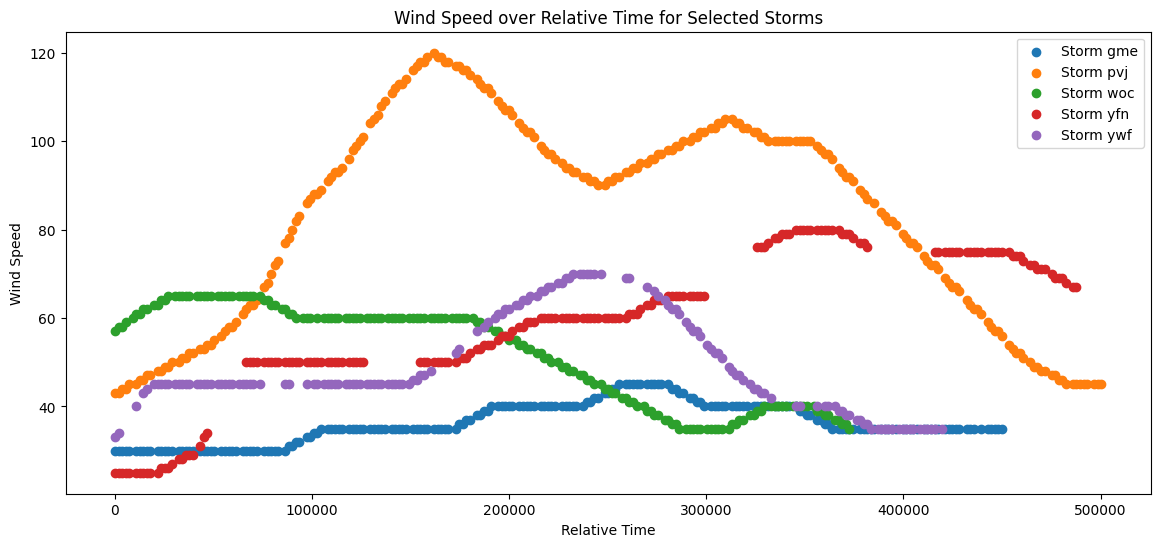

<Figure size 640x480 with 0 Axes>

In [ ]:
# Get all indexes with a value of 1
indices = [i for i, item in enumerate(storm_name) if item in clustered_storms[0]]

plt.figure(figsize=(14, 6))

for idx in indices:
    plt.scatter(x='relative_time', y='wind_speed', data=storm_df[idx], label=f'Storm {storm_name[idx]}')

plt.title('Wind Speed over Relative Time for Selected Storms')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

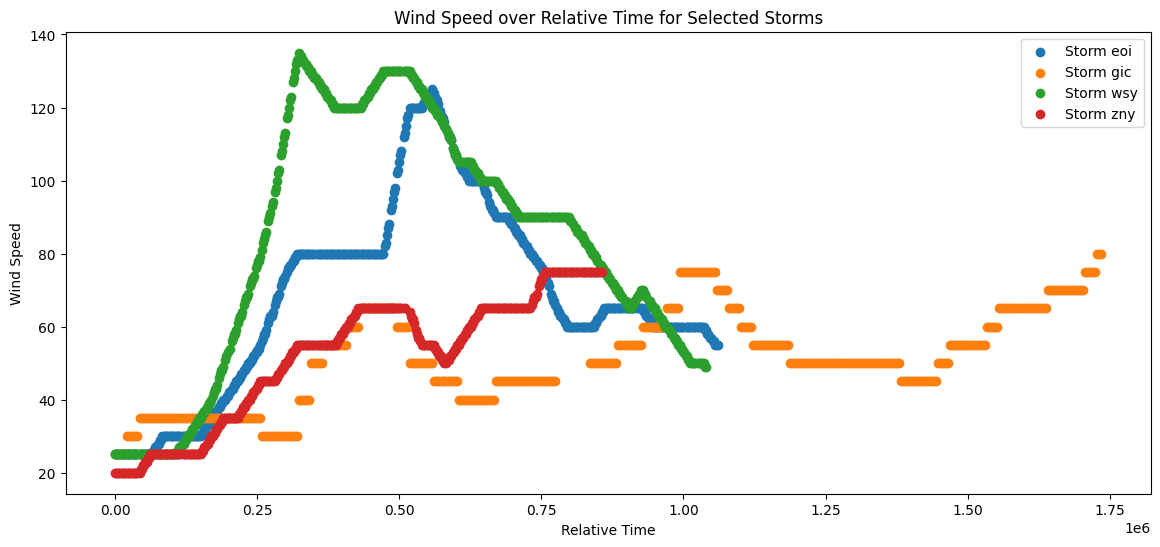

<Figure size 640x480 with 0 Axes>

In [ ]:
# Get all indexes with a value of 1
indices = [i for i, item in enumerate(storm_name) if item in clustered_storms[1]]

plt.figure(figsize=(14, 6))

for idx in indices:
    plt.scatter(x='relative_time', y='wind_speed', data=storm_df[idx], label=f'Storm {storm_name[idx]}')

plt.title('Wind Speed over Relative Time for Selected Storms')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

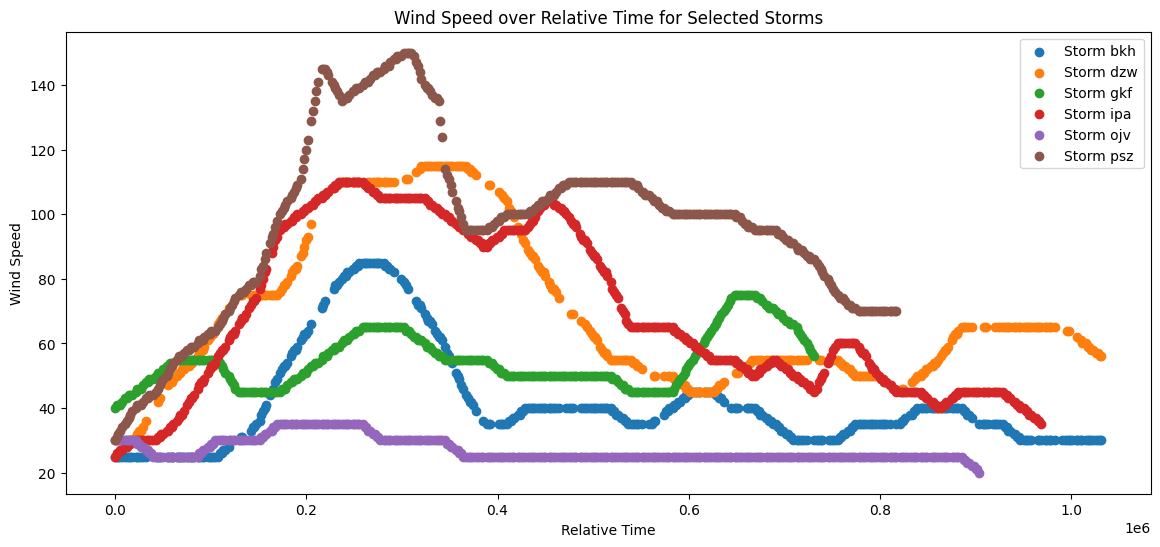

<Figure size 640x480 with 0 Axes>

In [ ]:
# Get all indexes with a value of 1
indices = [i for i, item in enumerate(storm_name) if item in clustered_storms[2]]

plt.figure(figsize=(14, 6))

for idx in indices:
    plt.scatter(x='relative_time', y='wind_speed', data=storm_df[idx], label=f'Storm {storm_name[idx]}')

plt.title('Wind Speed over Relative Time for Selected Storms')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

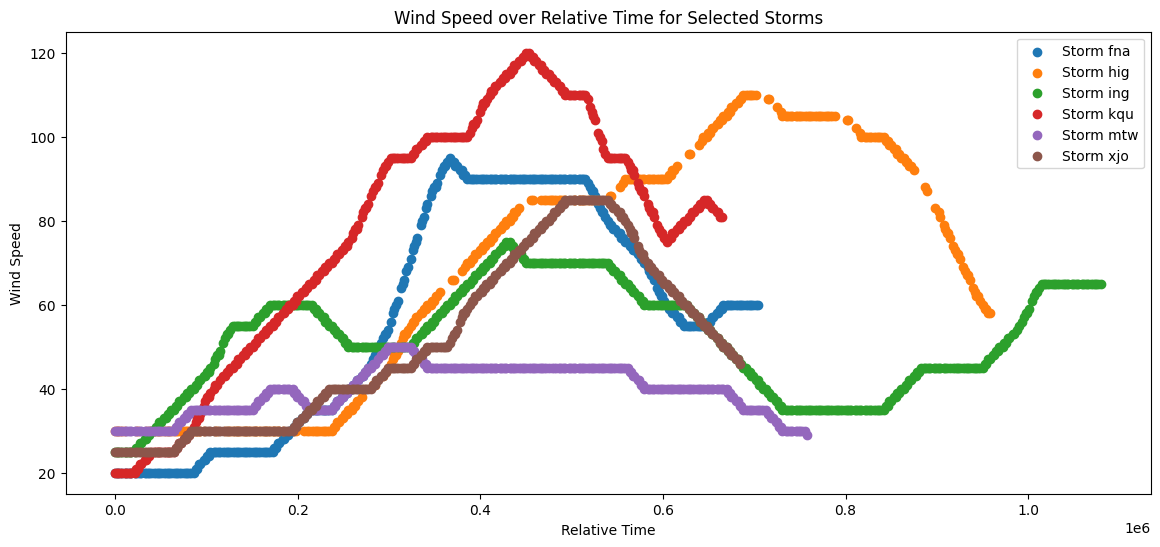

<Figure size 640x480 with 0 Axes>

In [ ]:
# Get all indexes with a value of 1
indices = [i for i, item in enumerate(storm_name) if item in clustered_storms[3]]

plt.figure(figsize=(14, 6))

for idx in indices:
    plt.scatter(x='relative_time', y='wind_speed', data=storm_df[idx], label=f'Storm {storm_name[idx]}')

plt.title('Wind Speed over Relative Time for Selected Storms')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

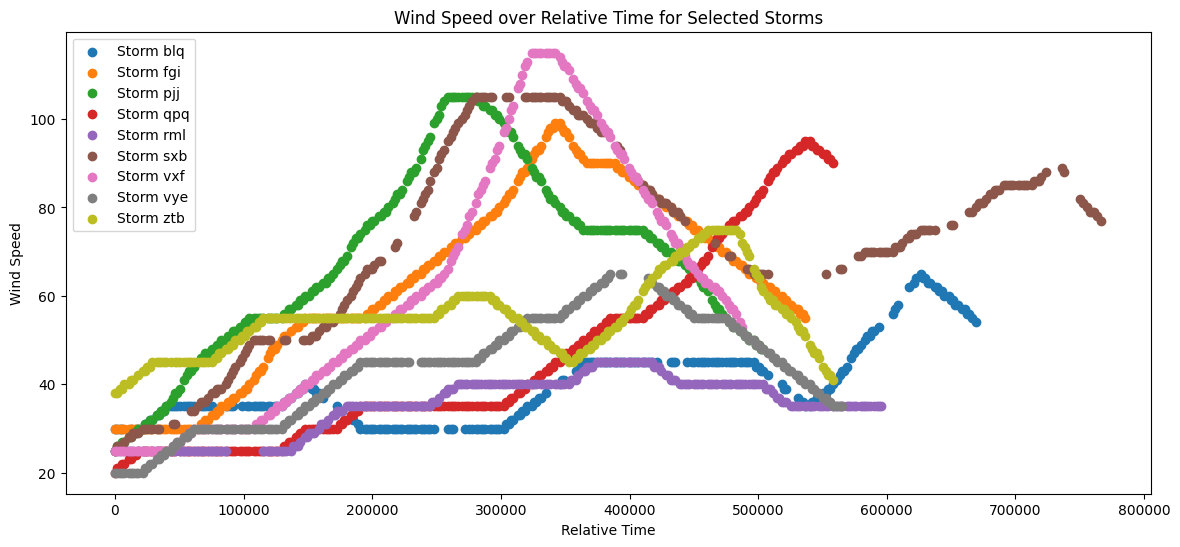

<Figure size 640x480 with 0 Axes>

In [ ]:
# Get all indexes with a value of 1
indices = [i for i, item in enumerate(storm_name) if item in clustered_storms[4]]

plt.figure(figsize=(14, 6))

for idx in indices:
    plt.scatter(x='relative_time', y='wind_speed', data=storm_df[idx], label=f'Storm {storm_name[idx]}')

plt.title('Wind Speed over Relative Time for Selected Storms')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

I manually adjust some of the storms so that the storms can be more similar in each cluster. The comparisons among the storms are plotted below.

In [28]:
clustered_storms = [
    ['gme', 'woc', 'yfn', 'ywf'],
    ['eoi', 'gic', 'wsy', 'zny'],
    ['bkh', 'dzw', 'ipa', 'ojv', 'psz', 'pvj'],
    ['fna', 'hig', 'ing', 'kqu', 'mtw', 'xjo'],
    ['fgi', 'pjj', 'sxb', 'vxf', 'vye'],
    ['blq', 'ztb', 'qpq', 'rml', 'gkf'],
]

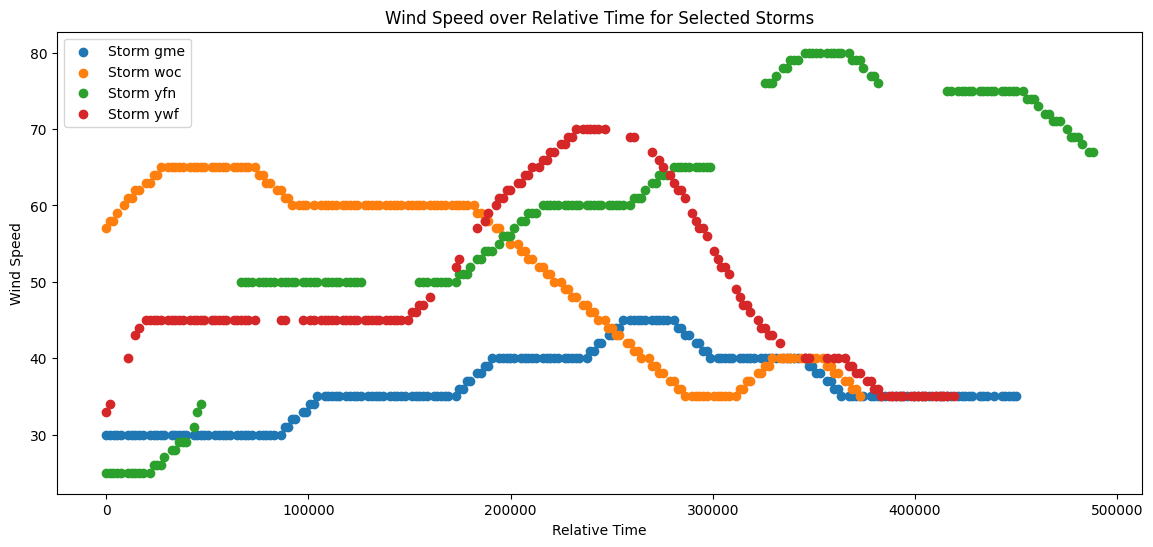

<Figure size 640x480 with 0 Axes>

In [29]:
# Get all indexes with a value of 1
indices = [i for i, item in enumerate(storm_name) if item in clustered_storms[0]]

plt.figure(figsize=(14, 6))

for idx in indices:
    plt.scatter(x='relative_time', y='wind_speed', data=storm_df[idx], label=f'Storm {storm_name[idx]}')

plt.title('Wind Speed over Relative Time for Selected Storms')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

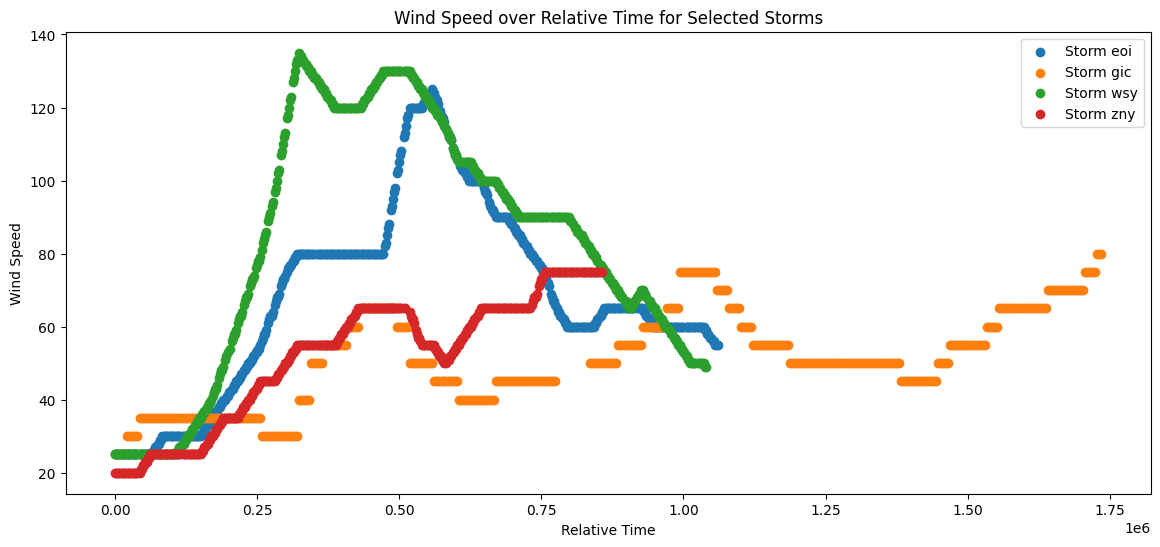

<Figure size 640x480 with 0 Axes>

In [16]:
# Get all indexes with a value of 1
indices = [i for i, item in enumerate(storm_name) if item in clustered_storms[1]]

plt.figure(figsize=(14, 6))

for idx in indices:
    plt.scatter(x='relative_time', y='wind_speed', data=storm_df[idx], label=f'Storm {storm_name[idx]}')

plt.title('Wind Speed over Relative Time for Selected Storms')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

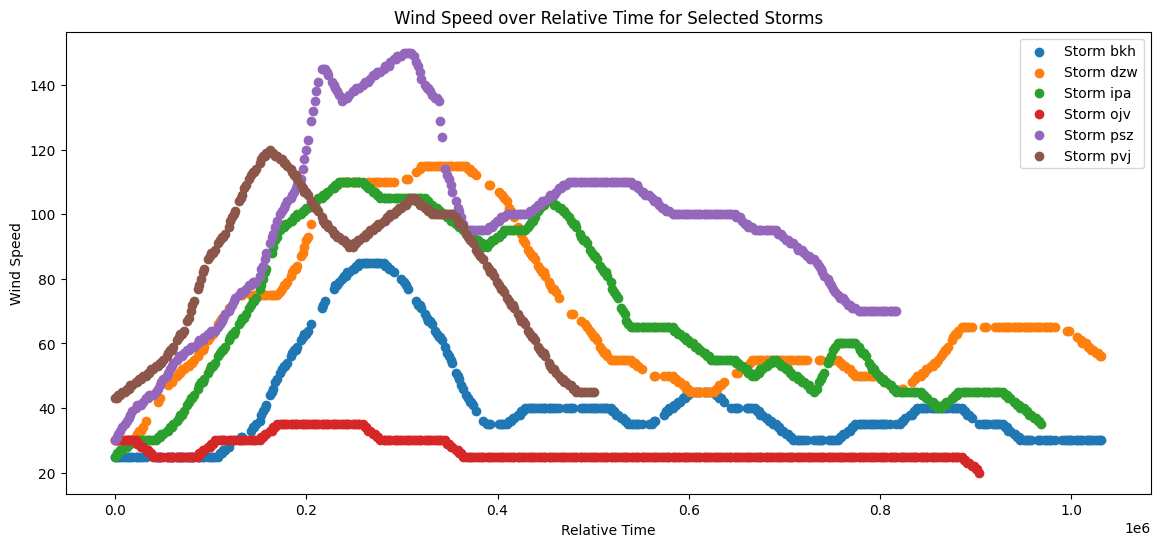

<Figure size 640x480 with 0 Axes>

In [17]:
# Get all indexes with a value of 1
indices = [i for i, item in enumerate(storm_name) if item in clustered_storms[2]]

plt.figure(figsize=(14, 6))

for idx in indices:
    plt.scatter(x='relative_time', y='wind_speed', data=storm_df[idx], label=f'Storm {storm_name[idx]}')

plt.title('Wind Speed over Relative Time for Selected Storms')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

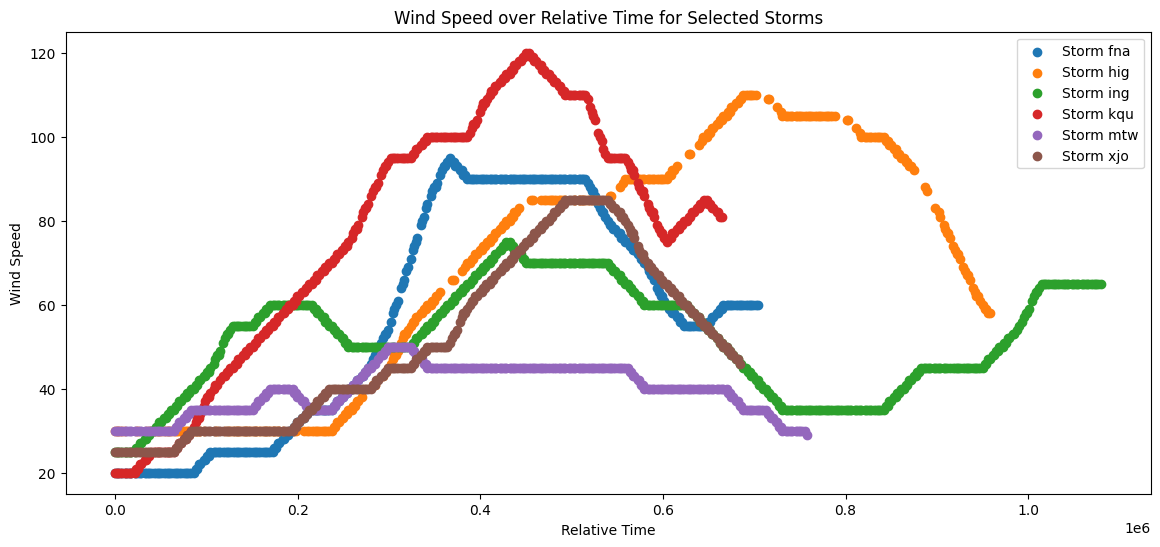

<Figure size 640x480 with 0 Axes>

In [18]:
# Get all indexes with a value of 1
indices = [i for i, item in enumerate(storm_name) if item in clustered_storms[3]]

plt.figure(figsize=(14, 6))

for idx in indices:
    plt.scatter(x='relative_time', y='wind_speed', data=storm_df[idx], label=f'Storm {storm_name[idx]}')

plt.title('Wind Speed over Relative Time for Selected Storms')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

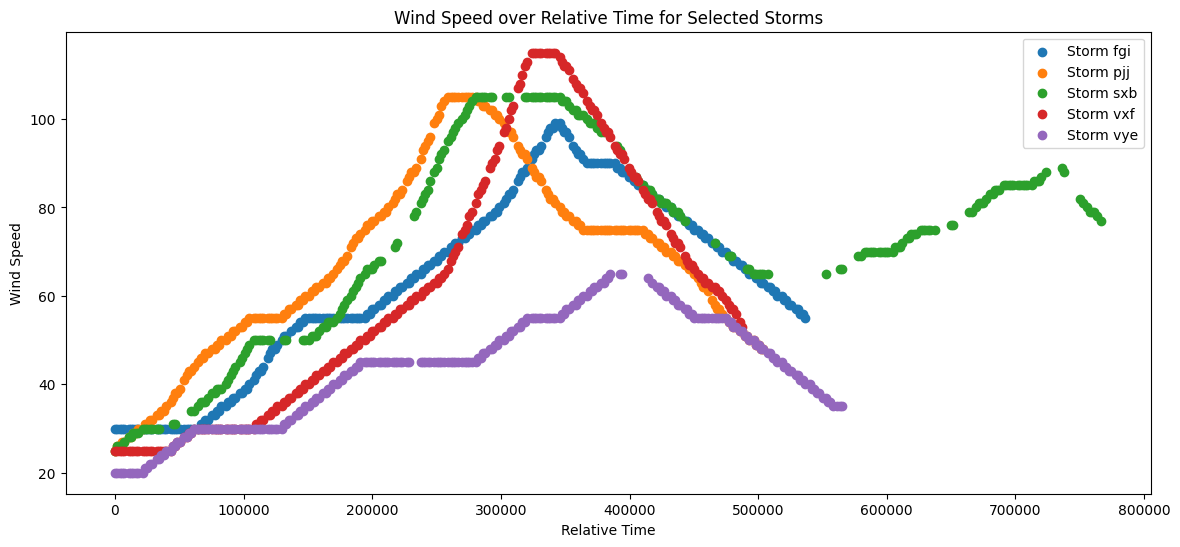

<Figure size 640x480 with 0 Axes>

In [19]:
# Get all indexes with a value of 1
indices = [i for i, item in enumerate(storm_name) if item in clustered_storms[4]]

plt.figure(figsize=(14, 6))

for idx in indices:
    plt.scatter(x='relative_time', y='wind_speed', data=storm_df[idx], label=f'Storm {storm_name[idx]}')

plt.title('Wind Speed over Relative Time for Selected Storms')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

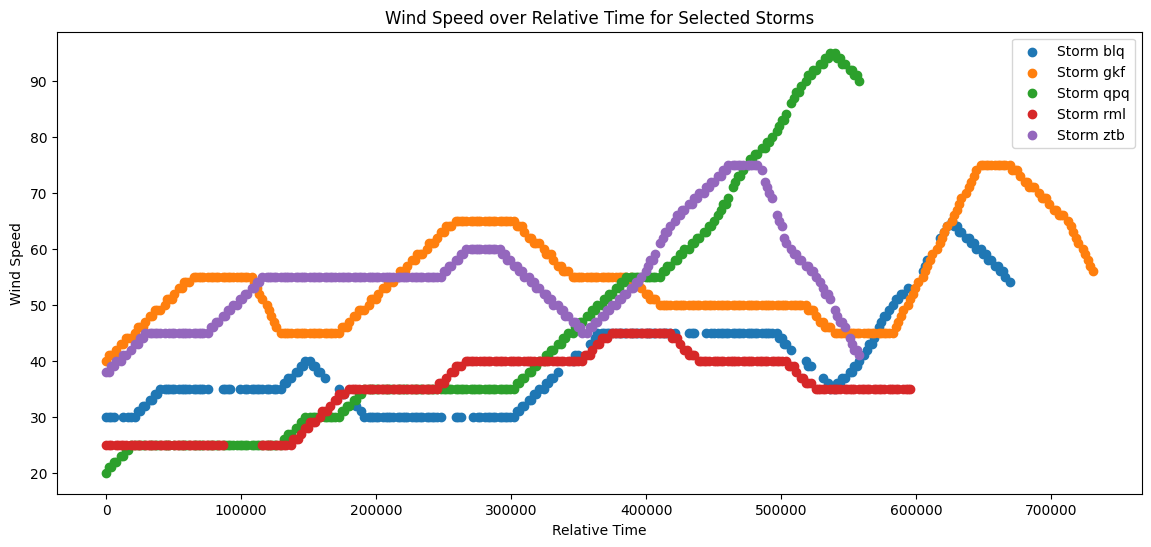

<Figure size 640x480 with 0 Axes>

In [20]:
# Get all indexes with a value of 1
indices = [i for i, item in enumerate(storm_name) if item in clustered_storms[5]]

plt.figure(figsize=(14, 6))

for idx in indices:
    plt.scatter(x='relative_time', y='wind_speed', data=storm_df[idx], label=f'Storm {storm_name[idx]}')

plt.title('Wind Speed over Relative Time for Selected Storms')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

Combine the csv files of the storms in one cluster together into a new csv file.

In [37]:
def combine_csv_files(file_list, output_file):
    """ Combine the CSV files in file_list together and save it as a new CSV file """
    dataframes = []
    for file_name in file_list:
        df = pd.read_csv(f"{os.path.join('storm_data', file_name)}_data.csv")  # Read CSV files
        dataframes.append(df)
    combined_df = pd.concat(dataframes)  # Combine DataFrame
    combined_df.to_csv(output_file, index=False)  # Save to a new CSV file

In [39]:
for i, storm_group in enumerate(clustered_storms):
    output_file = f"cluster_{i}.csv"
    combine_csv_files(storm_group, output_file)

# 8. Extract image features using PCA

In addition to the clustering according to the speed, we can also divide the storms in terms of the the features extracted from the images.

A reference to a package extracting features from images on temporal and spatial patterns is: https://xeofs.readthedocs.io/en/latest/auto_examples/1single/plot_eof-tmode.html#sphx-glr-auto-examples-1single-plot-eof-tmode-py

Install required packages.

In [ ]:
!pip install git+https://github.com/xarray-contrib/xeofs.git

Create a new custom dataset to load all the images.

In [15]:
class HurricaneDataset(Dataset):
    def __init__(self, subfolder_path, transform=None, image_size=(366, 366), channels=1, batch_size=15): # noqa
        """
        Initialize the dataset.
        Args:
            subfolder_path (string): Path to subfolder containing images.
            transform (callable, optional): Transform to be applied on an image. # noqa
            image_size (tuple): Target size for the images.
            channels (int): Number of channels in the images (1 for grayscale, 3 for RGB).
        """
        self.subfolder_path = subfolder_path
        self.channels = channels
        self.transform = transform if transform else self.default_transform(image_size) # noqa
        self.samples = self._load_samples()

    def _load_samples(self):
        """
        Load all image file paths from the subfolder.
        """
        return [os.path.join(self.subfolder_path, file) for file in sorted(os.listdir(self.subfolder_path)) if file.endswith('.jpg') and not file.startswith('._')] # noqa

    def default_transform(self, image_size):
        """
        Define default transformation: Resize, Convert to RGB or
        Grayscale, and Convert to Tensor.
        """
        transform_list = [transforms.Resize(image_size)]
        if self.channels == 1:
            transform_list.append(transforms.Grayscale(num_output_channels=1))
        elif self.channels == 3:
            transform_list.append(transforms.Lambda(lambda img: img.convert('RGB'))) # noqa
        transform_list.append(transforms.ToTensor())
        return transforms.Compose(transform_list)

    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        return len(self.samples)

    def __getitem__(self, idx):
        # Load image, apply transformations, etc.
        image = Image.open(self.samples[idx])
        if self.transform:
            image = self.transform(image)
        return np.array(image)

    def load_entire_dataset(self, batch_size):
        """
        Load the entire dataset and group into batches.
        Returns:
            numpy array of shape (num_batches, batch_size, height, width)
        """
        all_images = []
        for img_path in self.samples:
            image = Image.open(img_path)
            if self.transform:
                image = self.transform(image)
            image = np.array(image)
            if len(image.shape) == 3 and image.shape[0] == 1:
                image = image.squeeze(0)
            all_images.append(image)

        num_batches = len(all_images) // batch_size

        all_images_stacked = np.stack(all_images[:num_batches * batch_size], axis=0) # noqa
        all_images_stacked = all_images_stacked.reshape(num_batches, batch_size, *all_images_stacked.shape[1:]) # noqa

        return all_images_stacked

Import required packages.

In [16]:
from torch.optim import Adam

import xarray as xr
import xeofs as xe
# https://github.com/xarray-contrib/xeofs
from matplotlib.gridspec import GridSpec

I will select two storms to analyze ('bkh' and 'sxb').

Create the hurricane dataset and read the data from the csv file.

In [17]:
storm_name = 'bkh'
hurricane_dataset = HurricaneDataset(subfolder_path='Selected_Storms_curated_to_zip/{}'.format(storm_name), image_size=(64, 64), channels=1)
csv = pd.read_csv('storm_data/{}_data.csv'.format(storm_name))

Display the structure of the dataset.

In [18]:
ds = xr.Dataset(
    {"data": (("time", "x", "y"), np.array(hurricane_dataset).reshape(len(csv), 64, 64))},
    coords={"x": range(64), "y": range(64), "time": csv['relative_time']},
)
ds

<xarray.Dataset>
Dimensions:  (time: 410, x: 64, y: 64)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 54 55 56 57 58 59 60 61 62 63
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 54 55 56 57 58 59 60 61 62 63
  * time     (time) int64 0 1801 3600 5400 ... 1026001 1027801 1029601 1031401
Data variables:
    data     (time, x, y) float32 0.451 0.4471 0.3137 ... 0.0549 0.0549 0.0549

Build the model.

In [19]:
model = xe.models.EOF(n_modes=3)
model.fit(ds['data'], dim=['x','y'])

comps = model.components()  # EOFs (spatial patterns)
scores = model.scores()  # PCs (temporal patterns)
expvar = model.explained_variance_ratio()

Visualize the image features on temporal (left) and spatical (right) partterns.

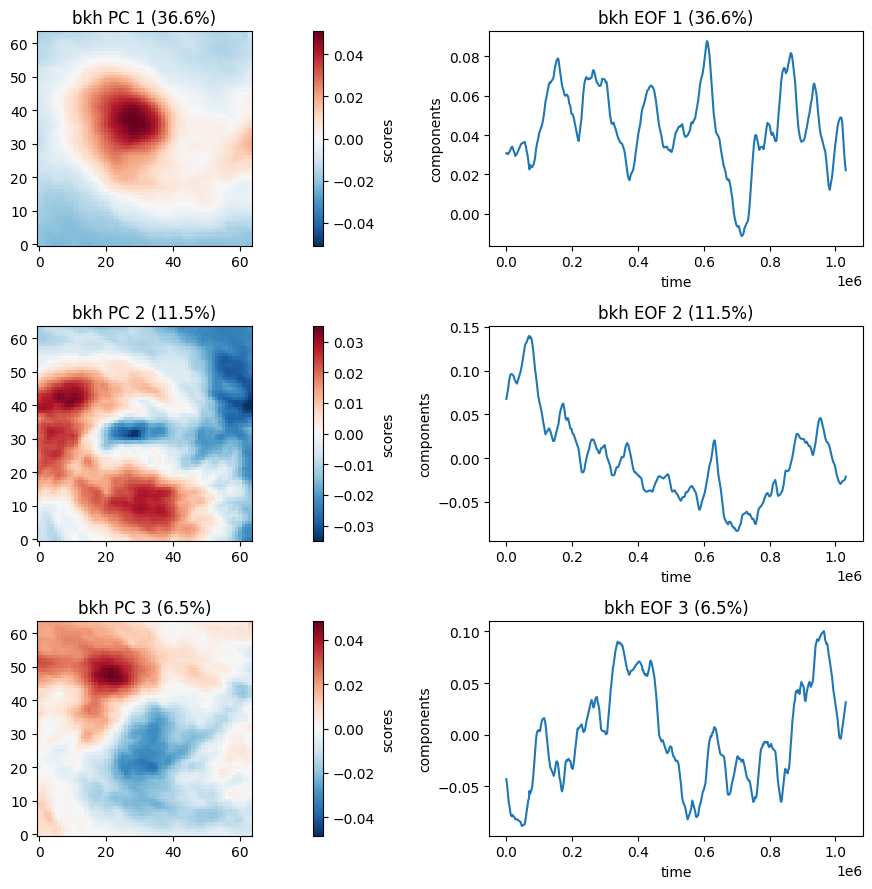

In [20]:
fig = plt.figure(figsize = (9, 9))
gs = GridSpec(3, 2, width_ratios=[1, 1])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(3)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(3)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    scores.sel(mode=i+1).plot(ax=a0)
    comps.sel(mode=i+1).plot(ax=a1)

    a0.set_xlabel('')
    a0.set_ylabel('')
    a0.axis('scaled')
    a0.set_title('{} PC {} ({:2.1f}%)'.format(storm_name, i+1, float(expvar[i]*100)))
    a1.set_title('{} EOF {} ({:2.1f}%)'.format(storm_name, i+1, float(expvar[i]*100)))

plt.tight_layout()

In [16]:
storm_name = 'sxb'
hurricane_dataset = HurricaneDataset(subfolder_path='Selected_Storms_curated_to_zip/{}'.format(storm_name), image_size=(64, 64), channels=1)
csv = pd.read_csv('storm_data/{}_data.csv'.format(storm_name))

In [17]:
ds = xr.Dataset(
    {"data": (("time", "x", "y"), np.array(hurricane_dataset).reshape(len(csv), 64, 64))},
    coords={"x": range(64), "y": range(64), "time": csv['relative_time']},
)
ds

<xarray.Dataset>
Dimensions:  (time: 243, x: 64, y: 64)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 54 55 56 57 58 59 60 61 62 63
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 54 55 56 57 58 59 60 61 62 63
  * time     (time) int64 0 1800 3600 5400 7200 ... 759598 761398 763198 766798
Data variables:
    data     (time, x, y) float32 0.3255 0.3137 0.4118 ... 0.07843 0.08235

In [18]:
model = xe.models.EOF(n_modes=3)
model.fit(ds['data'], dim=['x','y'])

comps = model.components()  # EOFs (spatial patterns)
scores = model.scores()  # PCs (temporal patterns)
expvar = model.explained_variance_ratio()

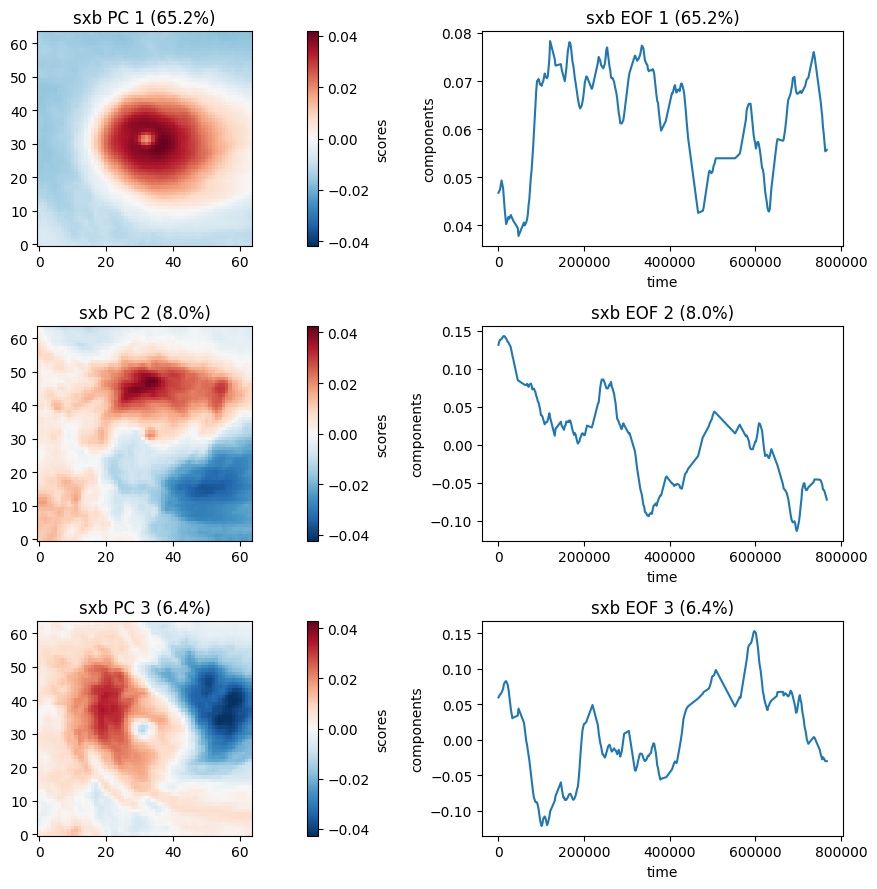

In [19]:
fig = plt.figure(figsize = (9, 9))
gs = GridSpec(3, 2, width_ratios=[1, 1])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(3)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(3)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    scores.sel(mode=i+1).plot(ax=a0)
    comps.sel(mode=i+1).plot(ax=a1)

    a0.set_xlabel('')
    a0.set_ylabel('')
    a0.axis('scaled')
    a0.set_title('{} PC {} ({:2.1f}%)'.format(storm_name, i+1, float(expvar[i]*100)))
    a1.set_title('{} EOF {} ({:2.1f}%)'.format(storm_name, i+1, float(expvar[i]*100)))

plt.tight_layout()

Then we can also group the storms together according to the extracted features on temperal and spatial features.

# 9. EDA on the new surprise storm

After we receive the surprise storm data, we should explore and analyse the new datasets.

Load the datasets and create the dataframes for the surprise storm.

In [6]:
image_path = os.path.join(root_dir, 'gdrive/MyDrive/tst')

surprise_dataset = HurricaneDataset(image_path, image_size=(366, 366), channels=1)
surprise_df = surprise_dataset.to_dataframe()

Display the first five rows of the surprise dataframe.

In [7]:
surprise_df.head()

image   image_name  step  \
0  [[[tensor(0.3804), tensor(0.3765), tensor(0.38...  tst_000.jpg     0   
1  [[[tensor(0.4784), tensor(0.4980), tensor(0.48...  tst_001.jpg     1   
2  [[[tensor(0.4353), tensor(0.4745), tensor(0.51...  tst_002.jpg     2   
3  [[[tensor(0.3765), tensor(0.4157), tensor(0.45...  tst_003.jpg     3   
4  [[[tensor(0.3686), tensor(0.4235), tensor(0.45...  tst_004.jpg     4   

  storm_id  relative_time  ocean  wind_speed  
0      tst              0      1          31  
1      tst           1800      1          32  
2      tst           3601      1          33  
3      tst           5400      1          33  
4      tst           7200      1          34

Display the shape of the surprise dataframe.

In [8]:
surprise_df.shape

(242, 7)

Print all the unique values of wind speeds for the surprise storm.

In [9]:
print(sorted(surprise_df['wind_speed'].unique()))

[31, 32, 33, 34, 36, 37, 38, 39, 41, 42, 43, 44, 46, 47, 48, 49, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125]


Display the descriptive statistics of the wind speeds for the chosen storm.

In [10]:
surprise_df['wind_speed'].describe()

count    242.000000
mean      84.177686
std       24.635884
min       31.000000
25%       63.000000
50%       83.000000
75%      100.000000
max      125.000000
Name: wind_speed, dtype: float64

Plot the histogram showing the distribution of wind speeds for the chosen storm.

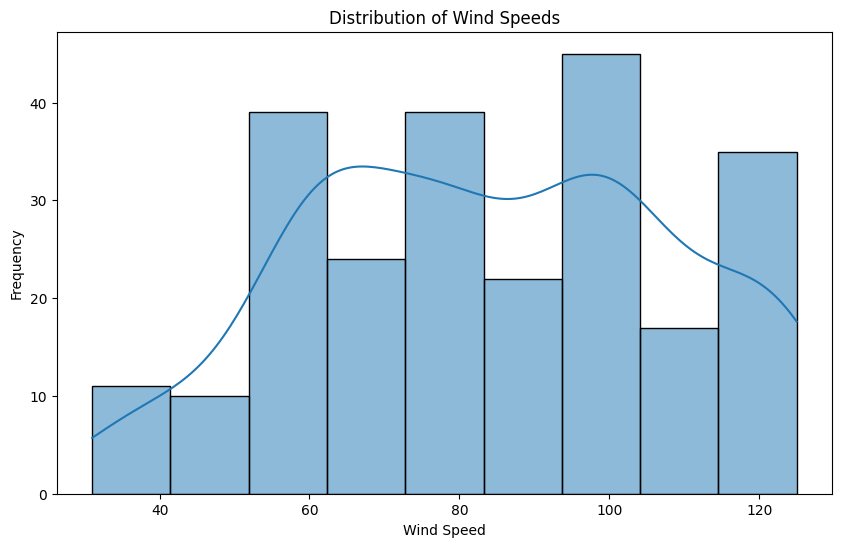

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(surprise_df['wind_speed'], kde=True)
plt.title('Distribution of Wind Speeds')
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.show()

Display an image of the surprise storm with the minimum speed.

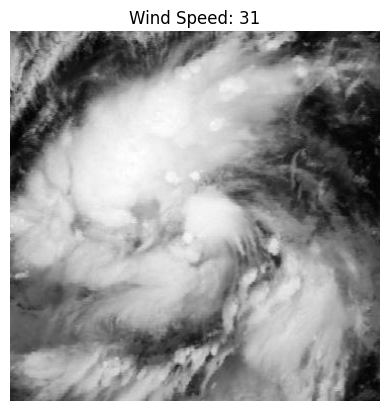

In [12]:
show_image_at_wind_speed(surprise_df, surprise_df['wind_speed'].min())

Display an image of the surprise storm with the maximum speed.

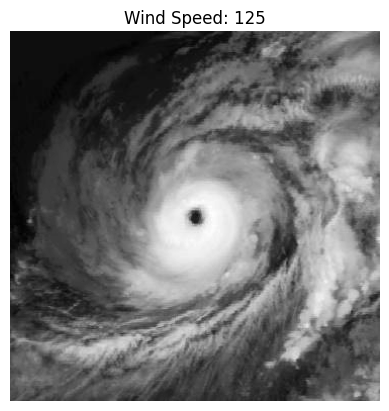

In [13]:
show_image_at_wind_speed(surprise_df, surprise_df['wind_speed'].max())

Plot the scatter diagram of the wind speed over relative time for the surprise storm.

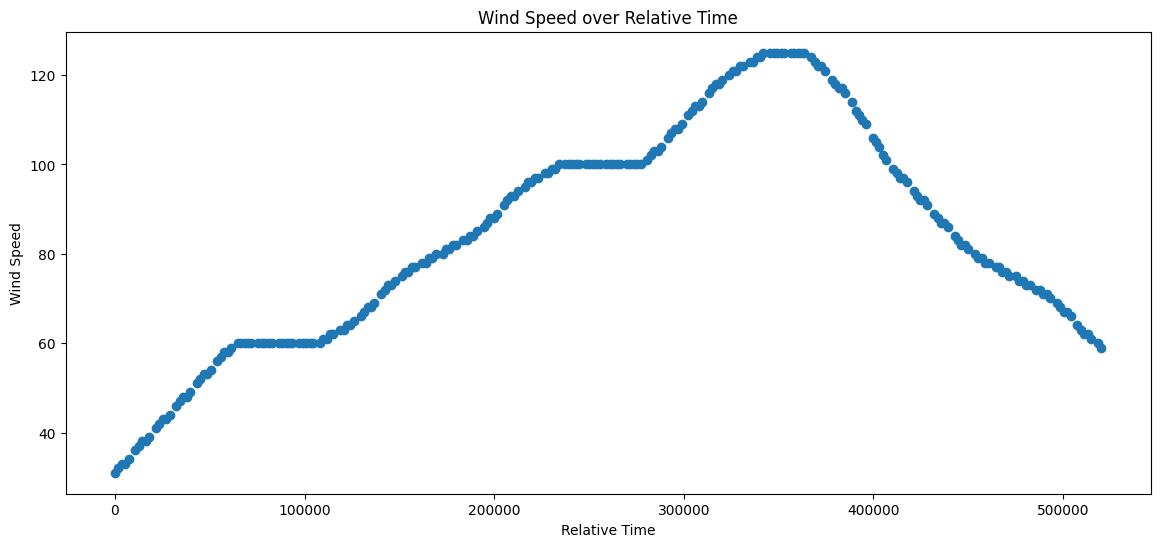

In [14]:
plt.figure(figsize=(14, 6))
plt.scatter(x='relative_time', y='wind_speed', data=surprise_df)
plt.title('Wind Speed over Relative Time')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.show()

Find the time differences between each two samples for the surprise storm.

In [15]:
differences = surprise_df['relative_time'].diff()
differences = differences.fillna(0)
print(sorted(differences.unique()))

[0.0, 1797.0, 1798.0, 1799.0, 1800.0, 1801.0, 1802.0, 1803.0, 3598.0, 3599.0, 3600.0, 3601.0, 3602.0, 3603.0]


Find the number and percentage of outliers in time steps (which are much larger than 1800) for the surprise storm.

In [16]:
count = (differences > 1805).sum()
percentage = count / len(differences)
print(f"Number of large time steps: {count}")
print(f"Percentage of large time steps: {percentage}")

Number of large time steps: 48
Percentage of large time steps: 0.19834710743801653


Find the feature 'ocean' for surprise storm.

In [20]:
ocean_values = surprise_df['ocean'].unique()
print(f"Unique values in 'ocean' column for surprise storm: {ocean_values}")

Unique values in 'ocean' column for surprise storm: [1]


Display the distribution of pixel intensity for the first image in the surprise storm. It can be seen from the graph below that the picture has a good quality.

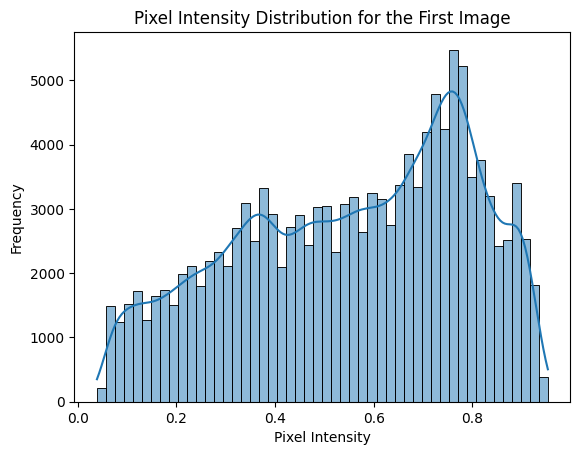

In [32]:
surprise_df['image'] = surprise_df['image'].apply(lambda x: np.array(x).flatten())

# Assuming we're analyzing the first image
sns.histplot(surprise_df['image'].iloc[0], bins=50, kde=True)
plt.title('Pixel Intensity Distribution for the First Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

Identify the number of images containing blank space for the surprise storm.

In [34]:
count = surprise_df['image'].apply(lambda img: (np.sum(np.array(img) == 1) / np.array(img).size) > 0.005).sum()

print(f"Number of images containing blank space: {count}")

Number of images containing blank space: 0


Find which cluster the surprise storm should be classified into.

In [39]:
clustered_storms = [
    ['gme', 'woc', 'yfn', 'ywf'],
    ['eoi', 'gic', 'wsy', 'zny'],
    ['bkh', 'dzw', 'ipa', 'ojv', 'psz', 'pvj'],
    ['fna', 'hig', 'ing', 'kqu', 'mtw', 'xjo'],
    ['fgi', 'pjj', 'sxb', 'vxf', 'vye'],
    ['blq', 'ztb', 'qpq', 'rml', 'gkf'],
]

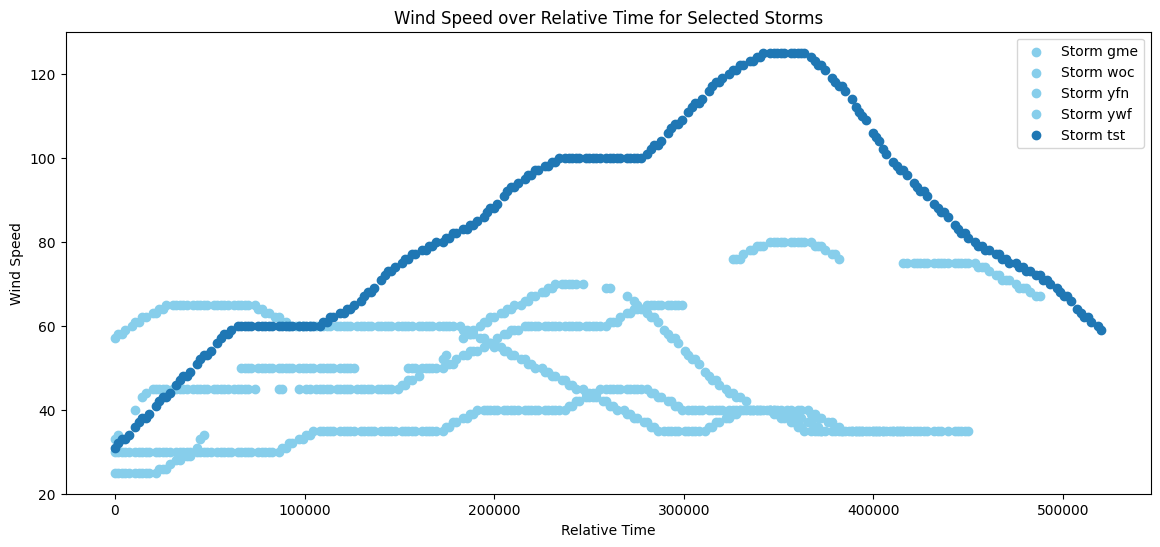

<Figure size 640x480 with 0 Axes>

In [55]:
indices = [i for i, item in enumerate(storm_name) if item in clustered_storms[0]]

plt.figure(figsize=(14, 6))

for idx in indices:
    plt.scatter(x='relative_time', y='wind_speed', data=storm_df[idx], c='skyblue', label=f'Storm {storm_name[idx]}')
plt.scatter(x='relative_time', y='wind_speed', data=surprise_df, label=f'Storm tst')

plt.title('Wind Speed over Relative Time for Selected Storms')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

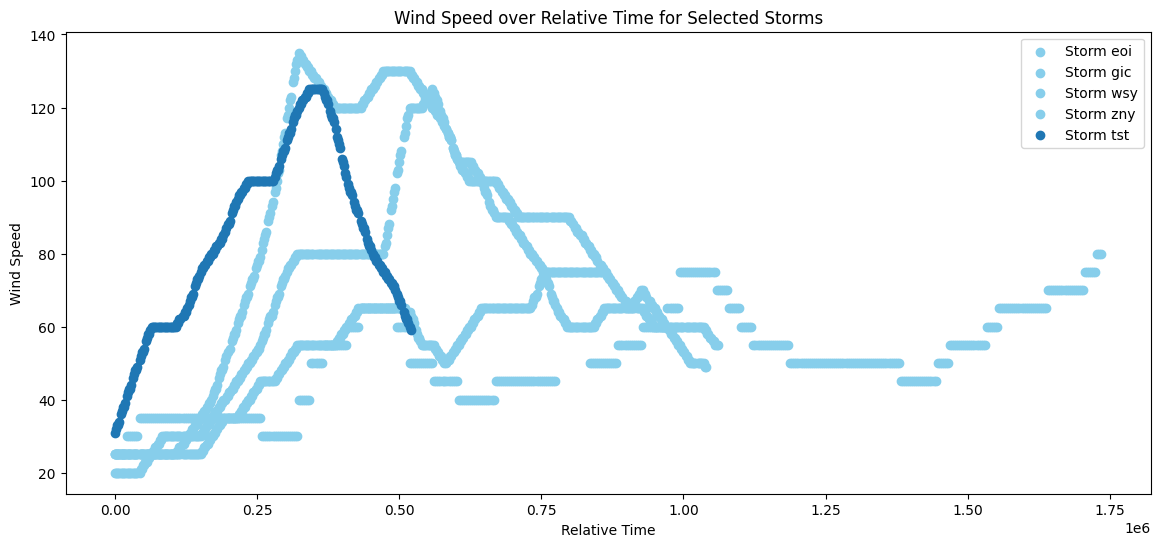

<Figure size 640x480 with 0 Axes>

In [53]:
indices = [i for i, item in enumerate(storm_name) if item in clustered_storms[1]]

plt.figure(figsize=(14, 6))

for idx in indices:
    plt.scatter(x='relative_time', y='wind_speed', c='skyblue', data=storm_df[idx], label=f'Storm {storm_name[idx]}')
plt.scatter(x='relative_time', y='wind_speed', data=surprise_df, label=f'Storm tst')

plt.title('Wind Speed over Relative Time for Selected Storms')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

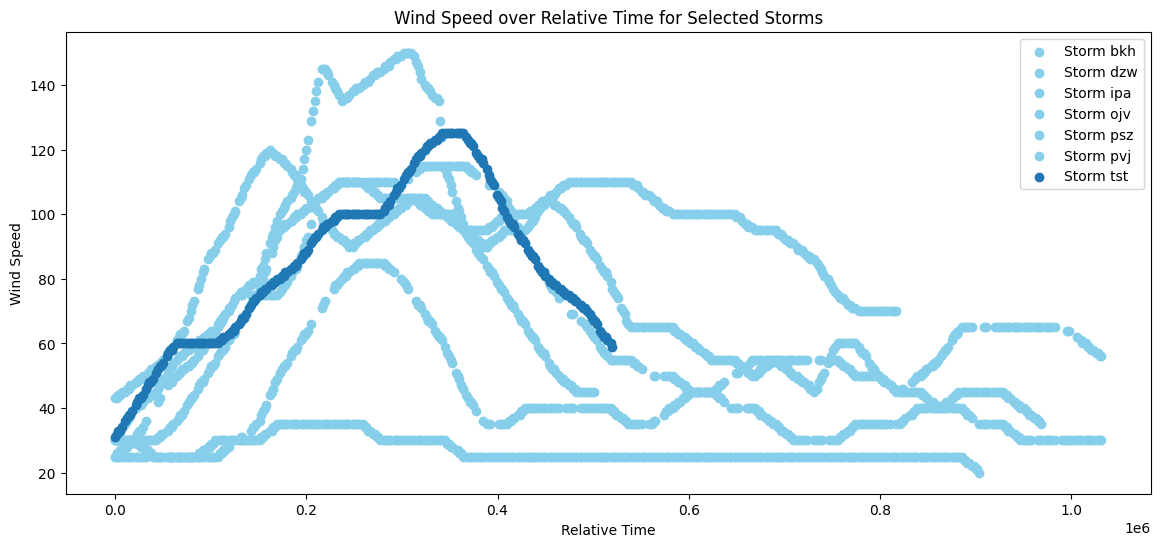

<Figure size 640x480 with 0 Axes>

In [57]:
indices = [i for i, item in enumerate(storm_name) if item in clustered_storms[2]]

plt.figure(figsize=(14, 6))

for idx in indices:
    plt.scatter(x='relative_time', y='wind_speed', c='skyblue', data=storm_df[idx], label=f'Storm {storm_name[idx]}')
plt.scatter(x='relative_time', y='wind_speed', data=surprise_df, label=f'Storm tst')

plt.title('Wind Speed over Relative Time for Selected Storms')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

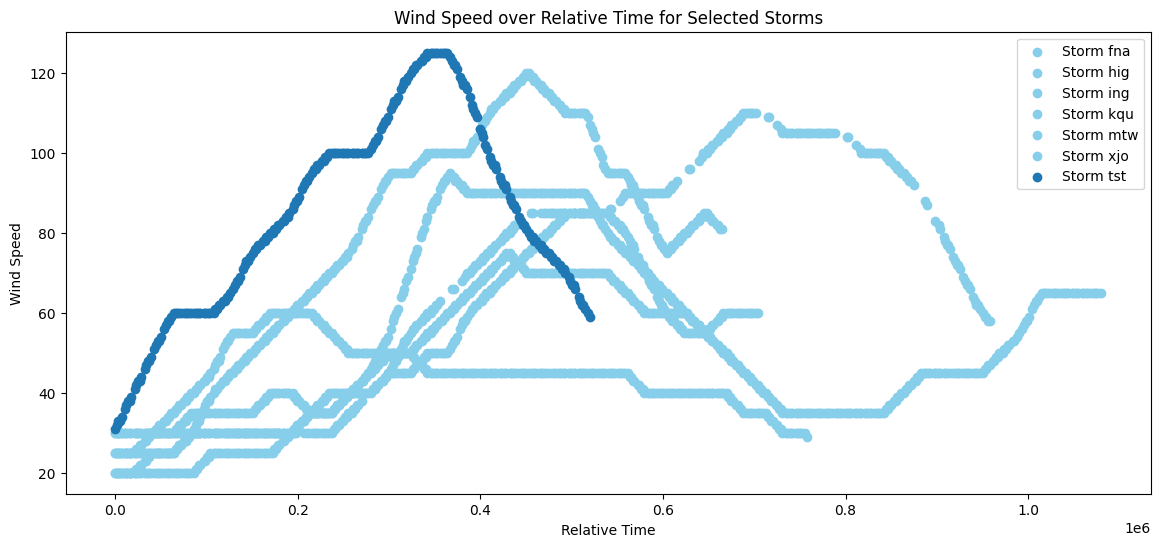

<Figure size 640x480 with 0 Axes>

In [58]:
indices = [i for i, item in enumerate(storm_name) if item in clustered_storms[3]]

plt.figure(figsize=(14, 6))

for idx in indices:
    plt.scatter(x='relative_time', y='wind_speed', c='skyblue', data=storm_df[idx], label=f'Storm {storm_name[idx]}')
plt.scatter(x='relative_time', y='wind_speed', data=surprise_df, label=f'Storm tst')

plt.title('Wind Speed over Relative Time for Selected Storms')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

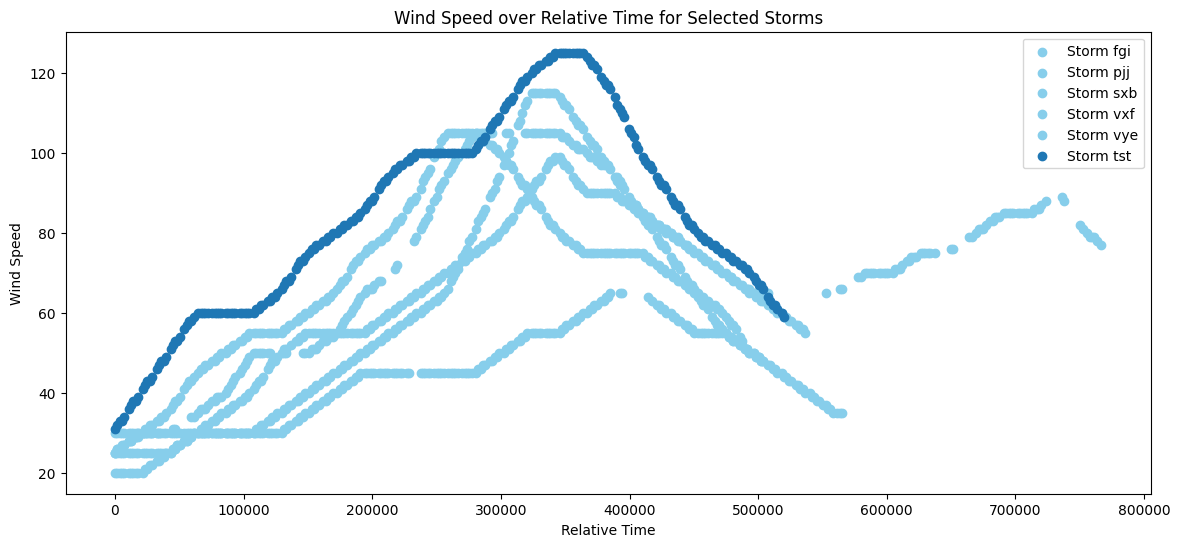

<Figure size 640x480 with 0 Axes>

In [59]:
indices = [i for i, item in enumerate(storm_name) if item in clustered_storms[4]]

plt.figure(figsize=(14, 6))

for idx in indices:
    plt.scatter(x='relative_time', y='wind_speed', c='skyblue', data=storm_df[idx], label=f'Storm {storm_name[idx]}')
plt.scatter(x='relative_time', y='wind_speed', data=surprise_df, label=f'Storm tst')

plt.title('Wind Speed over Relative Time for Selected Storms')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

From the plot above, it can be seen that the surprise storm 'tst' suits this cluster very well.

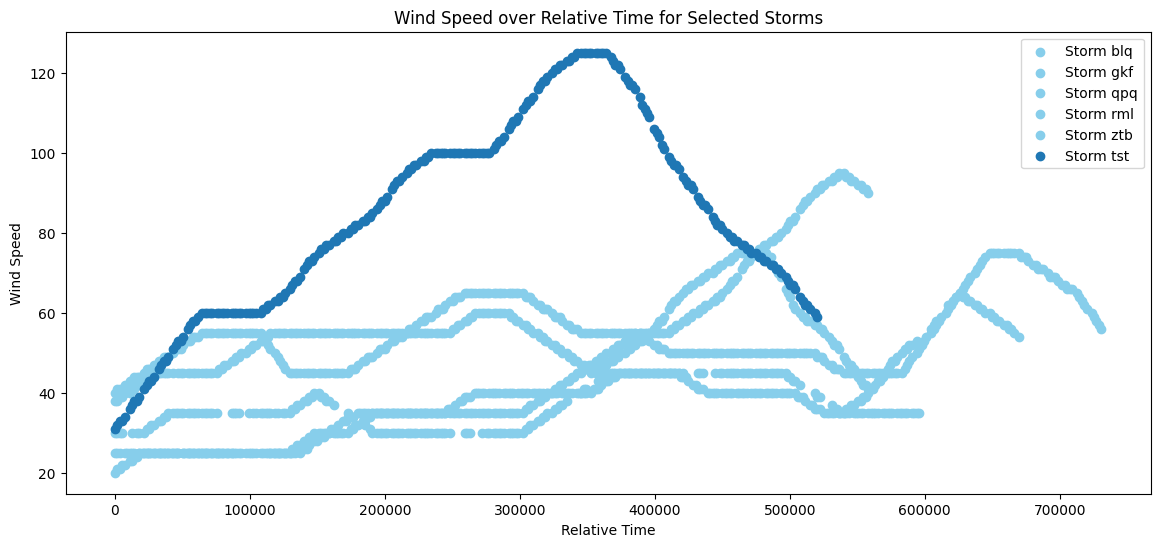

<Figure size 640x480 with 0 Axes>

In [60]:
indices = [i for i, item in enumerate(storm_name) if item in clustered_storms[5]]

plt.figure(figsize=(14, 6))

for idx in indices:
    plt.scatter(x='relative_time', y='wind_speed', c='skyblue', data=storm_df[idx], label=f'Storm {storm_name[idx]}')
plt.scatter(x='relative_time', y='wind_speed', data=surprise_df, label=f'Storm tst')

plt.title('Wind Speed over Relative Time for Selected Storms')
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()